## Business Problem

Oceanside Property Management is a property management company located in San Diego California. Their main business is, of course, managing rental properties. However, given the rise of Airbnb, they want to branch out and add a airbnb consulting as a service that they also provide. In their initial research they found that the top questions that potential clients have are:
- "What can I do to get more 5 star ratings?"
- "Can you help me reach Superhost status? (or maintain Superhost status)


Oceanside Property Management has decided that the main focus of their service will be helping clients get more 5 star reviews. Therefore they have tasked me with providing the following: 
- A model that will predict whether a specific unit will get a 5 Star Overall score based on other available information.
- An industry analysis of AirBnb in San Diego. Specifically looking for hidden gems that they can advise their clients to capitalize on.

They also want me to answer the following questions:
- Is there a significant advantage to being a Superhost? (is it worth all the effort to get this status and maintain it?)
- The benefits of being a 5 Star overall host, vs not being one. (again, is it worth all the work to have 5 Star overall rating)
- What factors are most important in determining a 5 Star Overall Rating? (what aspects should they most focus on)

## Understanding AirBnb

### Who uses AirBnb?

### AirBnb's Focus

### Importance of 5 Star Rating

### Importance of Superhost
- information from https://www.airbnb.com/d/superhost. Accessed 6/16/22

<b>Advantages: </b>|
- Superhost badge to stand out among other hosts.
- Customers can filter search results to show only superhosts.

<b>Requirements:</b>
- Minimum 4.8 overall rating.
- 10 stays over the last year.
- < 1% Cancellation Rate.
- At least 90% Response Rate.
- Reassessed every 3 months.

### Problems with Airbnb Data and/or Ratings System

The review data is incredibly skewed because Airbnb requires such a high rating. Even though there is a 5 point scale, 4.7 or lower is seen as a sign of doing a bad job. 

## Evaluation Metrics

<b><u>What I will be looking for in my models:</b></u>
- 1. <b>High Precision Score:</b> I want to make sure that I am identifying as many airbnb units that meet my target criteria as possible. I will keep this in balance by checking F1 Score.
- 2. <b>Good F1 Score:</b> While I am ultimately not concerned with Recall , a good F1 score means that the model is performing well on both Recall and Precision. Since Recall and Precision are inverses of each other, a good F1 score ensures that the model isn't skewed too far toward one or the other. (ie, a model that predicts EVERY customer is within my target would have perfect Recall, but would be useless).
- 3. <b>High Cross Validation Score:</b> This ensures that the model isn't overly trained on the test data and that it does a good job of predicted unseen and unknown data. (ie, the test set).
- 4. <b>Area Under the Curve (AUC):</b> The ROC AUC Score measures the Area under the ROC curve, which means that it classifies the true positive rate against the false positive rate. The higher the score, the better performing the model is. 

<b><u>That said, here is the scale that I will use to evaluate my models:</b></u>

- <b>.69 or less:</b> Model performs only slightly better than guessing and is worthless for my analysis.
- <b>.70 - .79:</b> Model still isn't performing very well, but is at minimum acceptable levels.
- <b>.80 - .89:</b> Model is performing fairly well. My goal is to be in this range or better.
- <b>.90 - .99:</b> Model is performing very well. I would be very happy to have a final model in this range.

## Loading Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier
import numpy as np


In [2]:
pd.set_option('display.max_rows', 1000)
plt.style.use('fivethirtyeight')

## Listing_DF: Baseline DF with many columns

In [3]:
listing_df = pd.read_csv('listings.csv.gz')

In [4]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

### Fixing Price
- Price is currently a string. I need to strip out the extra characters and convert the datatype to Float so that I can better utilize the data.

In [5]:
listing_df['price'].head(2)

0     $60.00
1    $282.00
Name: price, dtype: object

In [6]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [7]:
listing_df['price'].head(2)

0     60.0
1    282.0
Name: price, dtype: float64

## Base DF
- I am slicing out the columns that will be useful for analyzing and modeling the data, to make the dataframe more manageable.

In [8]:
base_df = listing_df[['price', 'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                      'review_scores_location', 'review_scores_value','accommodates', 'bedrooms', 'beds',
                      'instant_bookable', 'property_type', 'room_type', 'amenities', 'availability_365', 
                      'availability_30','availability_90','host_id', 'calculated_host_listings_count', 
                      'host_response_time', 'host_response_rate','host_is_superhost']]

In [9]:
df = base_df

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           10935 non-null  float64
 1   review_scores_rating            9408 non-null   float64
 2   review_scores_accuracy          9385 non-null   float64
 3   review_scores_cleanliness       9385 non-null   float64
 4   review_scores_checkin           9383 non-null   float64
 5   review_scores_communication     9385 non-null   float64
 6   review_scores_location          9383 non-null   float64
 7   review_scores_value             9383 non-null   float64
 8   accommodates                    10935 non-null  int64  
 9   bedrooms                        9905 non-null   float64
 10  beds                            10813 non-null  float64
 11  instant_bookable                10935 non-null  object 
 12  property_type                   

### Host Info

In [11]:
df['host_response_time'].value_counts()

within an hour        7911
within a few hours    1327
within a day           590
a few days or more     285
Name: host_response_time, dtype: int64

In [12]:
df['host_response_rate'].value_counts().head()

100%    7229
97%      354
98%      349
91%      279
99%      261
Name: host_response_rate, dtype: int64

In [13]:
df['instant_bookable'].value_counts()

f    5912
t    5023
Name: instant_bookable, dtype: int64

In [14]:
df['host_id'].value_counts()

88168913     219
429429981    163
3017970      119
226804666     85
147276739     76
            ... 
113819301      1
205127323      1
14767766       1
5039760        1
20667939       1
Name: host_id, Length: 5034, dtype: int64

### New Feature: Host Listings 5+
- Creating a new feature that tells whether a host has many listings.

In [75]:
df['calculated_host_listings_count'].value_counts().head()

1    2441
2    1109
3     627
4     429
5     315
Name: calculated_host_listings_count, dtype: int64

In [16]:
#df['host_listings_5+'] =df['calculated_host_listings_count'] >= 5

In [78]:
df['host_listings_1'] =df['calculated_host_listings_count'] == 1
df['host_listings_2-4'] = df['calculated_host_listings_count'].between(2, 4, inclusive=True)
df['host_listings_5-10'] = df['calculated_host_listings_count'].between(5, 10, inclusive=True)
df['host_listings_11-49'] = df['calculated_host_listings_count'].between(11, 49, inclusive=True)
df['host_listings_50+'] =df['calculated_host_listings_count'] >= 50

In [74]:
df['host_listings_50+'].value_counts()

False    7038
True      772
Name: host_listings_50+, dtype: int64

In [17]:
#df['host_listings_5+'].value_counts()

False    6392
True     4543
Name: host_listings_5+, dtype: int64

In [92]:
df.groupby('5_star').mean()

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,cleanliness_5,checkin_5,location_5,value_5,communication_5,host_listings_1,host_listings_2-4,host_listings_5-10,host_listings_11-49,host_listings_50+
5_star,,,,,,,,,,,,,,,,,,,,,
False,277.086445,4.475975,4.581919,4.533195,4.733178,4.689385,4.721746,4.456311,5.357538,1.986515,...,0.076418,0.168741,0.179806,0.033195,0.153527,0.190871,0.247580,0.161134,0.261065,0.139350
True,304.958926,4.929351,4.927233,4.892039,4.947715,4.950392,4.915826,4.839713,4.972143,1.963196,...,0.326962,0.455063,0.377389,0.230785,0.473973,0.384099,0.294632,0.118544,0.127694,0.075031


6392 records (out of 10935) are for hosts with 4 or less listings. (58%) This feature will help analyze whether having a large number of listings has any effect on having a 5 Star rating.

### New Feature: Capacity Ranges

In [18]:
df['accommodates'].value_counts()

2     2716
4     2306
6     1638
8      841
3      757
5      647
1      604
10     411
7      291
12     224
16     172
9      123
14      99
11      53
15      30
13      20
0        3
Name: accommodates, dtype: int64

In [19]:
df['capacity_couple'] = df['accommodates'] <= 2
df['capacity_family'] = df['accommodates'] == range(3 , 4)
df['capacity_large'] = df['accommodates'] <= 5

In [20]:
print((df['capacity_couple'] == True).sum())

3323


In [21]:
print((df['capacity_family'] == True).sum())

757


In [22]:
print((df['capacity_large'] == True).sum())

7033


### New Feature: Bedroom Ranges

In [23]:
df['bedrooms'].value_counts()

1.0     4621
2.0     2684
3.0     1538
4.0      665
5.0      254
6.0       87
7.0       25
8.0       16
10.0       6
9.0        5
11.0       2
12.0       2
Name: bedrooms, dtype: int64

46% of the units that I have bedroom data for are 1 bedroom. I will create a feature that groups units as either 1 bedroom or 2 or more.

In [93]:
df['bedrooms_1'] = df['bedrooms'] <= 1
df['bedrooms_2'] = df['bedrooms'] == 2
df['bedrooms_3+'] = df['bedrooms'] >= 3

In [95]:
df['bedrooms_3+'].value_counts()

False    5751
True     2059
Name: bedrooms_3+, dtype: int64

### New Feature: Bookings Above Average
- Booked: For the next 30 days, are more than average days booked? (less than 7 days left available)

In [26]:
df['availability_30'].value_counts()

0     2939
5      450
1      447
2      434
4      432
3      400
30     394
6      383
8      333
9      308
7      297
29     275
11     259
10     258
23     244
13     240
12     239
21     238
14     218
16     208
15     206
20     202
26     193
19     192
17     191
18     187
27     180
22     163
25     158
28     141
24     126
Name: availability_30, dtype: int64

In [27]:
df['availability_30'].describe()

count    10935.000000
mean         9.719707
std          9.791058
min          0.000000
25%          0.000000
50%          6.000000
75%         17.000000
max         30.000000
Name: availability_30, dtype: float64

In [28]:
df['availability_90'].value_counts()

0     1479
90     323
89     225
83     201
20     190
86     162
81     161
51     160
87     141
85     133
1      133
82     126
80     123
53     123
50     121
30     121
21     120
65     119
69     116
52     115
36     113
79     113
63     112
47     108
77     107
45     107
60     106
70     105
57     104
56     104
78     103
59     103
32     101
66     101
18     101
76     100
64     100
88      99
22      98
33      98
71      97
58      97
25      97
73      97
72      97
23      96
35      96
44      95
49      95
26      95
2       94
48      94
24      94
75      94
43      94
37      94
28      93
54      93
9       92
38      92
17      91
46      91
61      90
74      90
42      88
27      88
84      88
41      87
29      87
31      87
5       85
3       85
34      85
11      85
67      85
68      84
12      83
19      83
7       83
14      81
16      81
39      81
4       80
40      80
10      78
13      77
55      77
62      74
8       73
15      73
6       64

### CHANGE - BOOKED
- The median for availability 30 days out is 7 unbooked days. 
- I have made this a binary choice to indicate whether a unit is booked more often than the median, or less often than the median.

In [29]:
df['bookings_above_avg'] = df['availability_30'] <= 7
#df['bookings_above_avg'] = df['availability_90'] <= 45


In [30]:
df['bookings_above_avg'].value_counts()

True     5782
False    5153
Name: bookings_above_avg, dtype: int64

In [ ]:
#df.drop(['availability_30', 'availability_90', 'availability_365'], axis=1, inplace=True)

In [ ]:
df.info()

### New Feature: Host Response Rate 100
- Feature that determines whether a host has a perfect response rate.

In [100]:
df['host_response_rate'] = df['host_response_rate'].str.replace('%', ' ')
df['host_response_rate']  = df['host_response_rate'].astype('float')
df['host_response_100'] = df['host_response_rate'] == 100.0
df['host_response_90'] = df['host_response_rate'].between(90, 99, inclusive=True)
df['host_response_low'] = df['host_response_rate'] < 90

In [102]:
df['host_response_low'].value_counts()

False    7208
True      602
Name: host_response_low, dtype: int64

### Fixing Host is Superhost

Feature is currently a string instead of a bool. Correcting that so I can classify whether a host is a superhost or not.

In [33]:
df['host_is_superhost'] = df['host_is_superhost'].str.replace('f', 'False')
df['host_is_superhost'] = df['host_is_superhost'].str.replace('t', 'True')
df['superhost'] = df['host_is_superhost'] == 'True'
df['superhost'].value_counts()

False    6095
True     4840
Name: superhost, dtype: int64

### Fixing Instant Bookable
- Feature is currently a string instead of a bool. Correcting that so I can classify whether the unit can be instantly booked or not.

In [34]:
df['instant_bookable'] = df['instant_bookable'].str.replace('f', 'False')
df['instant_bookable'] = df['instant_bookable'].str.replace('t', 'True')
df['instant_bookable'] = df['instant_bookable'] == 'True'
df['instant_bookable'].value_counts()

False    5912
True     5023
Name: instant_bookable, dtype: int64

### New Feature: 5-Star Units
- this is my target feature. It classifies whether a unit has a 5.0 overall rating or not.

In [35]:
(df['review_scores_rating'] == 5.00).sum()

2054

In [36]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. If I drop them, I will lose 14% of my data.

In [37]:
nulls = df[df['review_scores_rating'].isna()]

In [38]:
nulls.head(3)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_is_superhost,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1,bedrooms_2+,bookings_above_avg,host_response_100,superhost
12,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,4.0,...,False,False,False,False,False,False,True,False,False,False
23,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1.0,...,False,True,False,False,True,True,False,False,False,False
70,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1.0,...,False,False,True,False,True,True,False,False,True,False


nulls appear to have no ratings. Let's drop them for now.

In [39]:
df = df.dropna()

<b> 8385 Records are left after dropping null values </b>

In [40]:
df.head(2)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,accommodates,bedrooms,...,host_is_superhost,host_listings_5+,capacity_couple,capacity_family,capacity_large,bedrooms_1,bedrooms_2+,bookings_above_avg,host_response_100,superhost
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,2,1.0,...,False,False,True,False,True,True,False,True,True,False
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,6,3.0,...,True,False,False,False,False,False,True,False,True,True


In [43]:
df['5_star'] = df['review_scores_rating'] >= 4.8

### Analysis:
- I have decided to classify "5 Star" units as ones that have a 4.8 or higher overall rating. I am doing this to allow a little leeway in the units, and also because 4.8 is the threshold that airbnb uses to determine whether a unit can become or remain a SuperHost.

In [44]:
df['5_star'].value_counts()

True     4918
False    2892
Name: 5_star, dtype: int64

### 5 Star Analysis:


### Creating Classifier Column

In [45]:
df['accuracy_5'] = df['review_scores_accuracy'] == 5.00
df['cleanliness_5'] = df['review_scores_cleanliness'] == 5.00
df['checkin_5'] = df['review_scores_checkin'] == 5.00
df['location_5'] = df['review_scores_location'] == 5.00
df['value_5'] = df['review_scores_value'] == 5.00
df['communication_5'] = df['review_scores_communication'] == 5.00

### Future Work: Analyze how much more likely a 5.0 rated rental is to be successful than a non-5.0 rated rental

### Creating Binned Price Categories

<b> It is difficult to analyze price because it is relative. A low priced home that sleeps 10 people still costs more than a high priced home that sleeps 2 </b>

In [ ]:
#df['price'].describe()

In [ ]:
#df['price_high'] = df['price'] >= 350
#df['price_low'] = df['price'] <= 120

In [ ]:
#df['price_high'] = df['price'] >= 200
#df['price_low'] = df['price'] < 200

In [ ]:
#df

### Stripped Rating: For Visualizations

In [ ]:
#df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [ ]:
#df['stripped_rating']

In [ ]:
#df = df.sort_values('stripped_rating', ascending=False)

In [ ]:
#df.info()

In [49]:
plot_df = df.sort_values('review_scores_rating', ascending=False)

## Attempting visualization

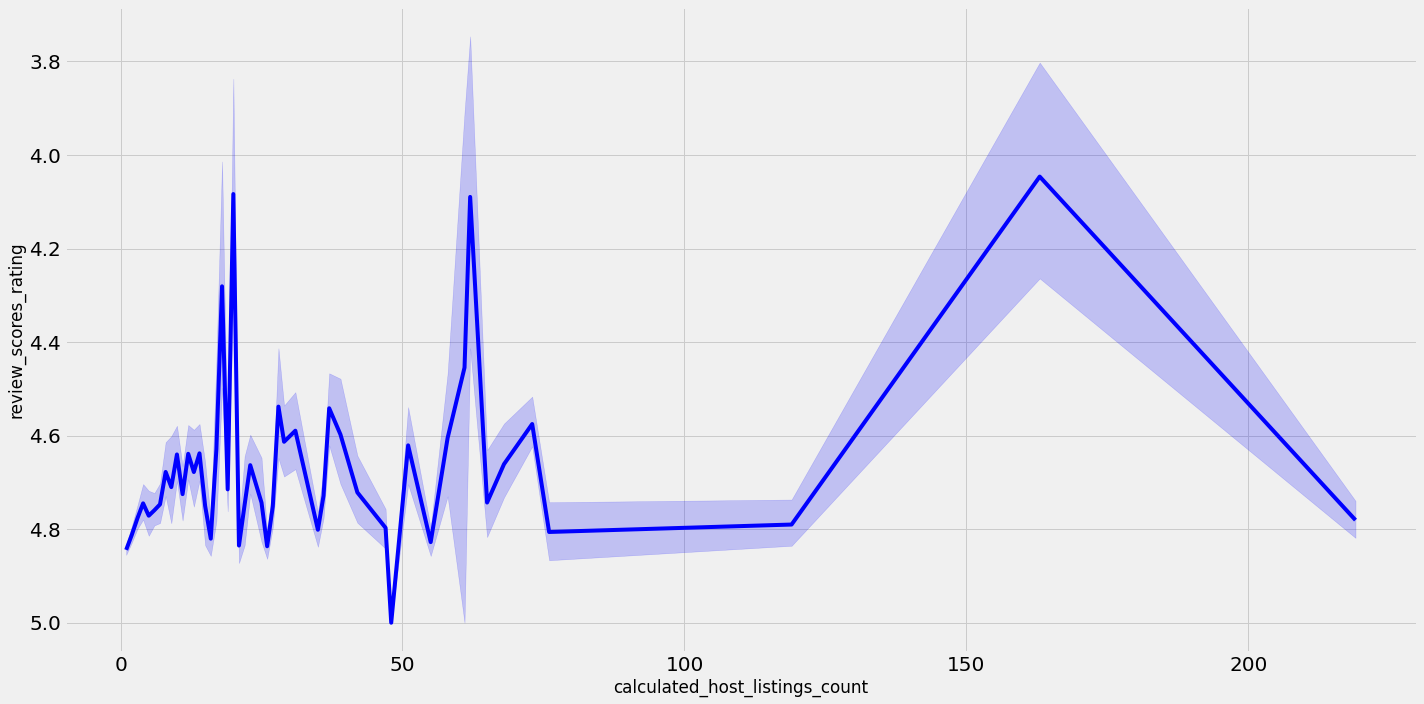

In [57]:
fig, ax = plt.subplots(figsize=(20, 10))

#p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');
#p = sns.lineplot(data=plot_df, x='review_scores_rating',y='calculated_host_listings_count', color='blue');
p = sns.lineplot(data=plot_df, x='calculated_host_listings_count', y='review_scores_rating', color='blue');

p.invert_yaxis()
#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [ ]:
#scatter_df = df[df['review_scores_rating'] >= 4.0]

In [ ]:
#scatter_mean = scatter_df['price'].mean()
#scatter_mean

In [ ]:
#fig, ax = plt.subplots(figsize=(20, 10))

#p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)

#fmt = '${x:,.0f}'
#tick = mtick.StrMethodFormatter(fmt)
#ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
#plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

#plt.tight_layout()

#plt.show();

### Creating Analysis_df

In [103]:
analysis_df = df.copy()

## EDA

In [ ]:
analysis_df['5_star'].value_counts()

<b>Analysis: Out of the 7810 Records in this dataset, 22.1% have a 5 Star Overall Rating </b>

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 10933
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   7

## Modelling

#### One Hot Encoding

In [109]:
need_to_encode = df[['5_star', 'accuracy_5', 'cleanliness_5', 'checkin_5', 'location_5', 'value_5',
                     'communication_5', 'room_type',  'bedrooms_1', 'bedrooms_2', 'bedrooms_3+',
                     'bookings_above_avg', 'instant_bookable', 'capacity_couple', 'capacity_family',
                     'capacity_large', 'host_listings_1', 'host_listings_2-4', 'host_listings_5-10',
                     'host_listings_11-49', 'host_listings_50+', 'superhost', 'host_response_100',
                     'host_response_90', 'host_response_low']]

                    
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,5_star_False,5_star_True,accuracy_5_False,accuracy_5_True,cleanliness_5_False,cleanliness_5_True,checkin_5_False,checkin_5_True,location_5_False,location_5_True,...,host_listings_50+_False,host_listings_50+_True,superhost_False,superhost_True,host_response_100_False,host_response_100_True,host_response_90_False,host_response_90_True,host_response_low_False,host_response_low_True
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [106]:
#old one

#need_to_encode = df[['5_star', 'accuracy_5', 'cleanliness_5', 'checkin_5', 'location_5', 'value_5',
 #                    'communication_5', 'room_type',  'bedrooms_1', 'bedrooms_2+', 'booked', 
  #                   'instant_bookable', 'capacity_couple', 'capacity_family', 'capacity_large',
   #                  'host_listings_5+', 'superhost', 'host_response_100', 'host_response_time']]
                     
                     # 'price_high', 'price_low',
                    #'capacity_1-4', 'capacity_5+',
                    # 'capacity_-2','capacity_-4', 'capacity_-6', 'capacity_-10', 'capacity_11+',
                    #'bedrooms_1', 'bedrooms_2', 'bedrooms_3', 'bedrooms_4+', 'instant_bookable']]
                    
#ohe = OneHotEncoder()
#ohe.fit(need_to_encode)

#ohe_1 = ohe.transform(need_to_encode).toarray()

#ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
#ohe_df.head(2)

In [ ]:
# Combining everything together
#cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
#cleaned_df.head(2)

In [110]:
cleaned_df = ohe_df

In [112]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 52 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   5_star_False               7810 non-null   float64
 1   5_star_True                7810 non-null   float64
 2   accuracy_5_False           7810 non-null   float64
 3   accuracy_5_True            7810 non-null   float64
 4   cleanliness_5_False        7810 non-null   float64
 5   cleanliness_5_True         7810 non-null   float64
 6   checkin_5_False            7810 non-null   float64
 7   checkin_5_True             7810 non-null   float64
 8   location_5_False           7810 non-null   float64
 9   location_5_True            7810 non-null   float64
 10  value_5_False              7810 non-null   float64
 11  value_5_True               7810 non-null   float64
 12  communication_5_False      7810 non-null   float64
 13  communication_5_True       7810 non-null   float

#### Dropping One Value for Categoricals

In [114]:
cleaned_df.drop(['5_star_False', 'accuracy_5_False', 'cleanliness_5_False', 'checkin_5_False', 'location_5_False',
                 'value_5_False', 'communication_5_False', 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3+_False',
                 'bookings_above_avg_False', 'instant_bookable_False', 'capacity_couple_False', 'capacity_family_False',
                 'capacity_large_False', 'host_listings_1_False', 'host_listings_2-4_False', 'host_listings_5-10_False',
                 'host_listings_11-49_False', 'host_listings_50+_False', 'superhost_False', 'host_response_100_False',
                     'host_response_90_False', 'host_response_low_False'], axis=1, inplace=True)

In [116]:
#old one

#cleaned_df.drop(['5_star_False', 'accuracy_5_False', 'cleanliness_5_False', 'checkin_5_False',
 #                             'location_5_False','value_5_False', 'bedrooms_1_False', 'bedrooms_2+_False',
    #                          'capacity_couple_False', 'capacity_family_False', 'capacity_large_False',
      #                        'instant_bookable_False', 'booked_False', 'room_type_Hotel room',
       #                       'host_response_100_False', 'communication_5_False', 'superhost_False',
        #                      'host_listings_5+_False'], axis=1, inplace=True)
                              
                              
                              #'price_high_False', 'price_low_False',
                           # 'bedrooms_1_False', 'bedrooms_2_False', 'bedrooms_3_False', 'bedrooms_4+_False',
                             
                            #'capacity_1-4_False', 'capacity_5+_False',
                             # 'capacity_-2_False','capacity_-4_False', 'capacity_-6_False',
                             # 'capacity_-10_False', 'capacity_11+_False',
                            

### 5_Star and Low Rated DFs Created

In [117]:
five_star_df = cleaned_df[cleaned_df['5_star_True'] == 1]
low_rated_df = cleaned_df[cleaned_df['5_star_True'] == 0]

In [118]:
five_star_df.describe()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,...,capacity_large_True,host_listings_1_True,host_listings_2-4_True,host_listings_5-10_True,host_listings_11-49_True,host_listings_50+_True,superhost_True,host_response_100_True,host_response_90_True,host_response_low_True
count,4918.0,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,...,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000,4918.000000
mean,1.0,0.366612,0.326962,0.455063,0.377389,0.230785,0.473973,0.822489,0.000610,0.172631,...,0.615087,0.384099,0.294632,0.118544,0.127694,0.075031,0.660228,0.786702,0.147621,0.065677
std,0.0,0.481928,0.469151,0.498027,0.484783,0.421378,0.499373,0.382140,0.024693,0.377967,...,0.486624,0.486431,0.455923,0.323284,0.333783,0.263467,0.473680,0.409678,0.354760,0.247742
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [119]:
low_rated_df.describe()

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,...,capacity_large_True,host_listings_1_True,host_listings_2-4_True,host_listings_5-10_True,host_listings_11-49_True,host_listings_50+_True,superhost_True,host_response_100_True,host_response_90_True,host_response_low_True
count,2892.0,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,...,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000,2892.000000
mean,0.0,0.069502,0.076418,0.168741,0.179806,0.033195,0.153527,0.844398,0.000692,0.142462,...,0.562932,0.190871,0.247580,0.161134,0.261065,0.139350,0.260028,0.640387,0.263140,0.096473
std,0.0,0.254350,0.265711,0.374588,0.384092,0.179176,0.360557,0.362540,0.026293,0.349584,...,0.496110,0.393056,0.431681,0.367718,0.439291,0.346371,0.438725,0.479970,0.440414,0.295290
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
cleaned_df['5_star_True'].value_counts()

1.0    4918
0.0    2892
Name: 5_star_True, dtype: int64

#### Dealing with Class Imbalance

- <b> Solution </b>
    - Always use class weight parameter in Decision Tree Classifier
    - Always stratify Train Test Split.
    - Add SMOTE to Training Sets.

In [121]:
cleaned_df.isna().sum()

5_star_True                  0
accuracy_5_True              0
cleanliness_5_True           0
checkin_5_True               0
location_5_True              0
value_5_True                 0
communication_5_True         0
room_type_Entire home/apt    0
room_type_Hotel room         0
room_type_Private room       0
room_type_Shared room        0
bedrooms_1_True              0
bedrooms_2_True              0
bedrooms_3+_True             0
bookings_above_avg_True      0
instant_bookable_True        0
capacity_couple_True         0
capacity_family_True         0
capacity_large_True          0
host_listings_1_True         0
host_listings_2-4_True       0
host_listings_5-10_True      0
host_listings_11-49_True     0
host_listings_50+_True       0
superhost_True               0
host_response_100_True       0
host_response_90_True        0
host_response_low_True       0
dtype: int64

In [122]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7810 entries, 0 to 7809
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   5_star_True                7810 non-null   float64
 1   accuracy_5_True            7810 non-null   float64
 2   cleanliness_5_True         7810 non-null   float64
 3   checkin_5_True             7810 non-null   float64
 4   location_5_True            7810 non-null   float64
 5   value_5_True               7810 non-null   float64
 6   communication_5_True       7810 non-null   float64
 7   room_type_Entire home/apt  7810 non-null   float64
 8   room_type_Hotel room       7810 non-null   float64
 9   room_type_Private room     7810 non-null   float64
 10  room_type_Shared room      7810 non-null   float64
 11  bedrooms_1_True            7810 non-null   float64
 12  bedrooms_2_True            7810 non-null   float64
 13  bedrooms_3+_True           7810 non-null   float

In [123]:
review_df = cleaned_df[['5_star_True', 'accuracy_5_True', 'cleanliness_5_True', 'checkin_5_True',
                       'location_5_True', 'value_5_True', 'communication_5_True']]
review_df

,5_star_True,accuracy_5_True,cleanliness_5_True,checkin_5_True,location_5_True,value_5_True,communication_5_True
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
7805,1.0,0.0,1.0,1.0,1.0,0.0,0.0
7806,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7807,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7808,1.0,0.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
high_listing_df = cleaned_df[cleaned_df['host_listings_5+_True'] == True]

In [ ]:
high_listing_df.describe()

### <b>Train Test Split</b>

In [124]:
balanced_df = cleaned_df.copy()

#balanced_df = high_listing_df.copy()
#balanced_df = review_df.copy()
#balanced_df = new_df.copy()

#balanced_df.drop(['accuracy_5_True', 'communication_5_True', 'cleanliness_5_True', 'checkin_5_True' ], axis=1, inplace=True)

X = balanced_df.drop(['5_star_True'], axis=1)
y = balanced_df['5_star_True']
#X = balanced_df.drop(['booked_True'], axis=1)
#y = balanced_df['booked_True']
#X = balanced_df.drop(['accuracy_5_True'], axis=1)
#y = balanced_df['accuracy_5_True']
#X = balanced_df.drop(['communication_5_True'], axis=1)
#y = balanced_df['communication_5_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

### Metrics Function

In [125]:
def get_metrics(clf, y_pred):
    
    
    #clf_acc = accuracy_score(y_test, y_pred) * 100
    #print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    #clf_rcl = recall_score(y_test, y_pred) * 100
    #print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))
    clf_cv_score = np.mean(cross_val_score(clf, X_train_resampled, y_train_resampled, cv=10))
    print('Cross Validation Score is :{0}'.format(round(clf_cv_score, 3)))

### Choosing Evaluation Metrics
- My goal is to predict whether a person will get a perfect 5.0 Airbnb rating.
- Which is worse?
    - Model predicts that someone has a perfect rating, but they actually don't? (more false Positives)
    - Model predicts that someone does not have a perfect rating, but they actually do? (more false negatives)

<b> Decision </b>
- I want false Positives to be as low as possible.
- If my model says that a property will have a 5.0 score, I want it to be a near guarantee.
- If it misses some that will still get a 5.0 score that is fine.
- <b>Therefore, I am most concerned with Precision, balanced out by F1 score.</b>

In [ ]:
X.describe()

## Baseline Decision Tree

In [126]:
#w/out SMOTE
dt0 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt0.fit(X_train, y_train)
dt0_y_pred = dt0.predict(X_test)
get_metrics(dt0, dt0_y_pred)

Precision is :81.83361629881153
F1 Score is :80.06644518272424
ROC AUC is :0.74
Cross Validation Score is :0.786


In [127]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)
get_metrics(dt1, dt1_y_pred)

Precision is :81.48457047539617
F1 Score is :80.44462741869081
ROC AUC is :0.74
Cross Validation Score is :0.786


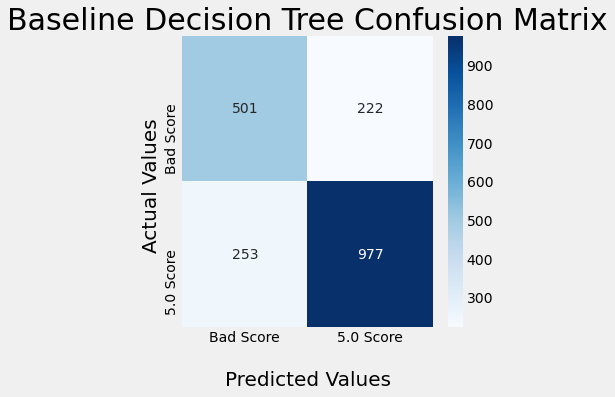

In [128]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [129]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [130]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)
dt_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

## Decision Tree 2

In [131]:
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=5,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)
get_metrics(dt2, dt2_y_pred)

Precision is :81.5702479338843
F1 Score is :80.90163934426229
ROC AUC is :0.75
Cross Validation Score is :0.786


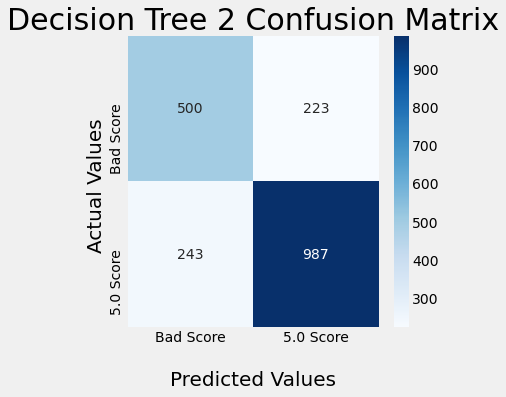

In [132]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Decision Tree 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [133]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)
get_metrics(rf1_clf, rf1_y_pred)

Precision is :82.43559718969556
F1 Score is :84.10991636798089
ROC AUC is :0.77
Cross Validation Score is :0.811


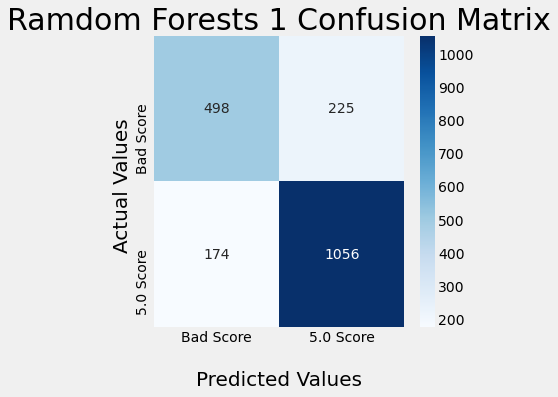

In [134]:
rf1_matrix = confusion_matrix(y_test, rf1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Ramdom Forests 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch CV

In [135]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [136]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'precision', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 30}


## Random Forests 2

In [137]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 2, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 30, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)
get_metrics(rf2_clf, rf2_y_pred)

Precision is :86.65395614871306
F1 Score is :79.77182974989029
ROC AUC is :0.77
Cross Validation Score is :0.774


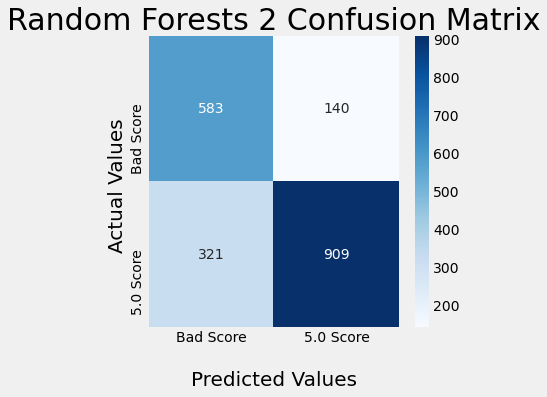

In [138]:
rf2_matrix = confusion_matrix(y_test, rf2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(rf2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Random Forests 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## XGBoost Model

In [139]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)
get_metrics(xg1, xg1_y_pred)

Precision is :82.86821705426357
F1 Score is :84.84126984126985
ROC AUC is :0.78
Cross Validation Score is :0.811


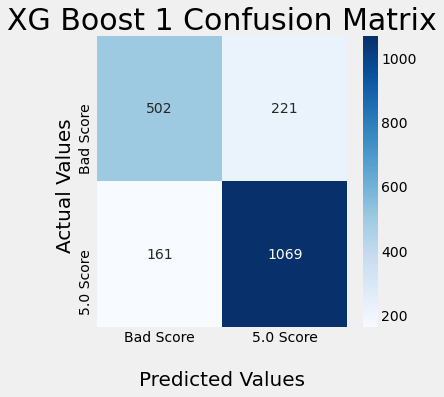

In [140]:
xg1_matrix = confusion_matrix(y_test, xg1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 1 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### GridSearch

In [141]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

## XGBoost 2

In [142]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='precision', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [143]:
xg2 = XGBClassifier(learning_rate= 0.2, max_depth=6, min_child_weight=1,
                                n_estimators=100, subsample=0.7, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)
get_metrics(xg2, xg2_y_pred)

Precision is :82.96239447429011
F1 Score is :85.3533359652586
ROC AUC is :0.79
Cross Validation Score is :0.813


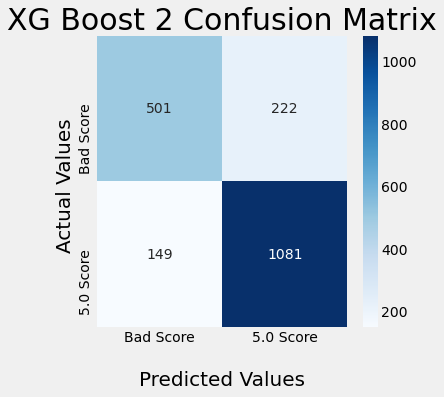

In [144]:
xg2_matrix = confusion_matrix(y_test, xg2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(xg2_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('XG Boost 2 Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## FINAL MODEL = XG Boost 2

In [145]:
get_metrics(xg2, xg2_y_pred)
#get_metrics(rf1_clf, rf1_y_pred)

Precision is :82.96239447429011
F1 Score is :85.3533359652586
ROC AUC is :0.79
Cross Validation Score is :0.813


### Model Evaluation:
- <b> Precision: </b> This Model correctly picks whether a rental will receive a perfect 5 star overall AirBnb rating 78.4% of the time.
    - This is nearly 30% better than random guessing.
    - The Final Model is also a slight improvement over the baseline model. (about 7% better)
- <b> Recall and F1 Score: </b> The Final Model's recall and F1 Scores are higher than the baseline model. The F1 Score indicates that Precision is reasonably balanced with Recall.
- <b> ROC AUC Score: </b> Shows the True Positive Rate vs. the False Postive Rate. My Random Forests 2 Model performed better on this metric, but also captured more false positives. I want to avoid false positives if at all possible, so I chose XG Boost 1 over Random Forests 2.
- <b> Cross Validation Score: </b> The high score shows that this model does a good job with new data that it was not trained on.

### How to use This Model going forward

## Feature Importance

In [146]:
feature_names = list(X)
xg2_importance = xg2.feature_importances_

In [147]:
#feature_importance_df = pd.DataFrame(dt2_importance, feature_names)
#feature_importance_df = pd.DataFrame(rf2_importance, feature_names)
feature_importance_df = pd.DataFrame(xg2_importance, feature_names)
feature_importance_df= feature_importance_df.reset_index()
feature_importance_df.rename(columns={'index': 'Feature', 0: 'Importance'}, inplace=True)
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,accuracy_5_True,0.201557
23,superhost_True,0.176652
5,communication_5_True,0.060608
18,host_listings_1_True,0.043012
1,cleanliness_5_True,0.039629
4,value_5_True,0.031700
25,host_response_90_True,0.031295
2,checkin_5_True,0.031012
14,instant_bookable_True,0.025867
3,location_5_True,0.024378


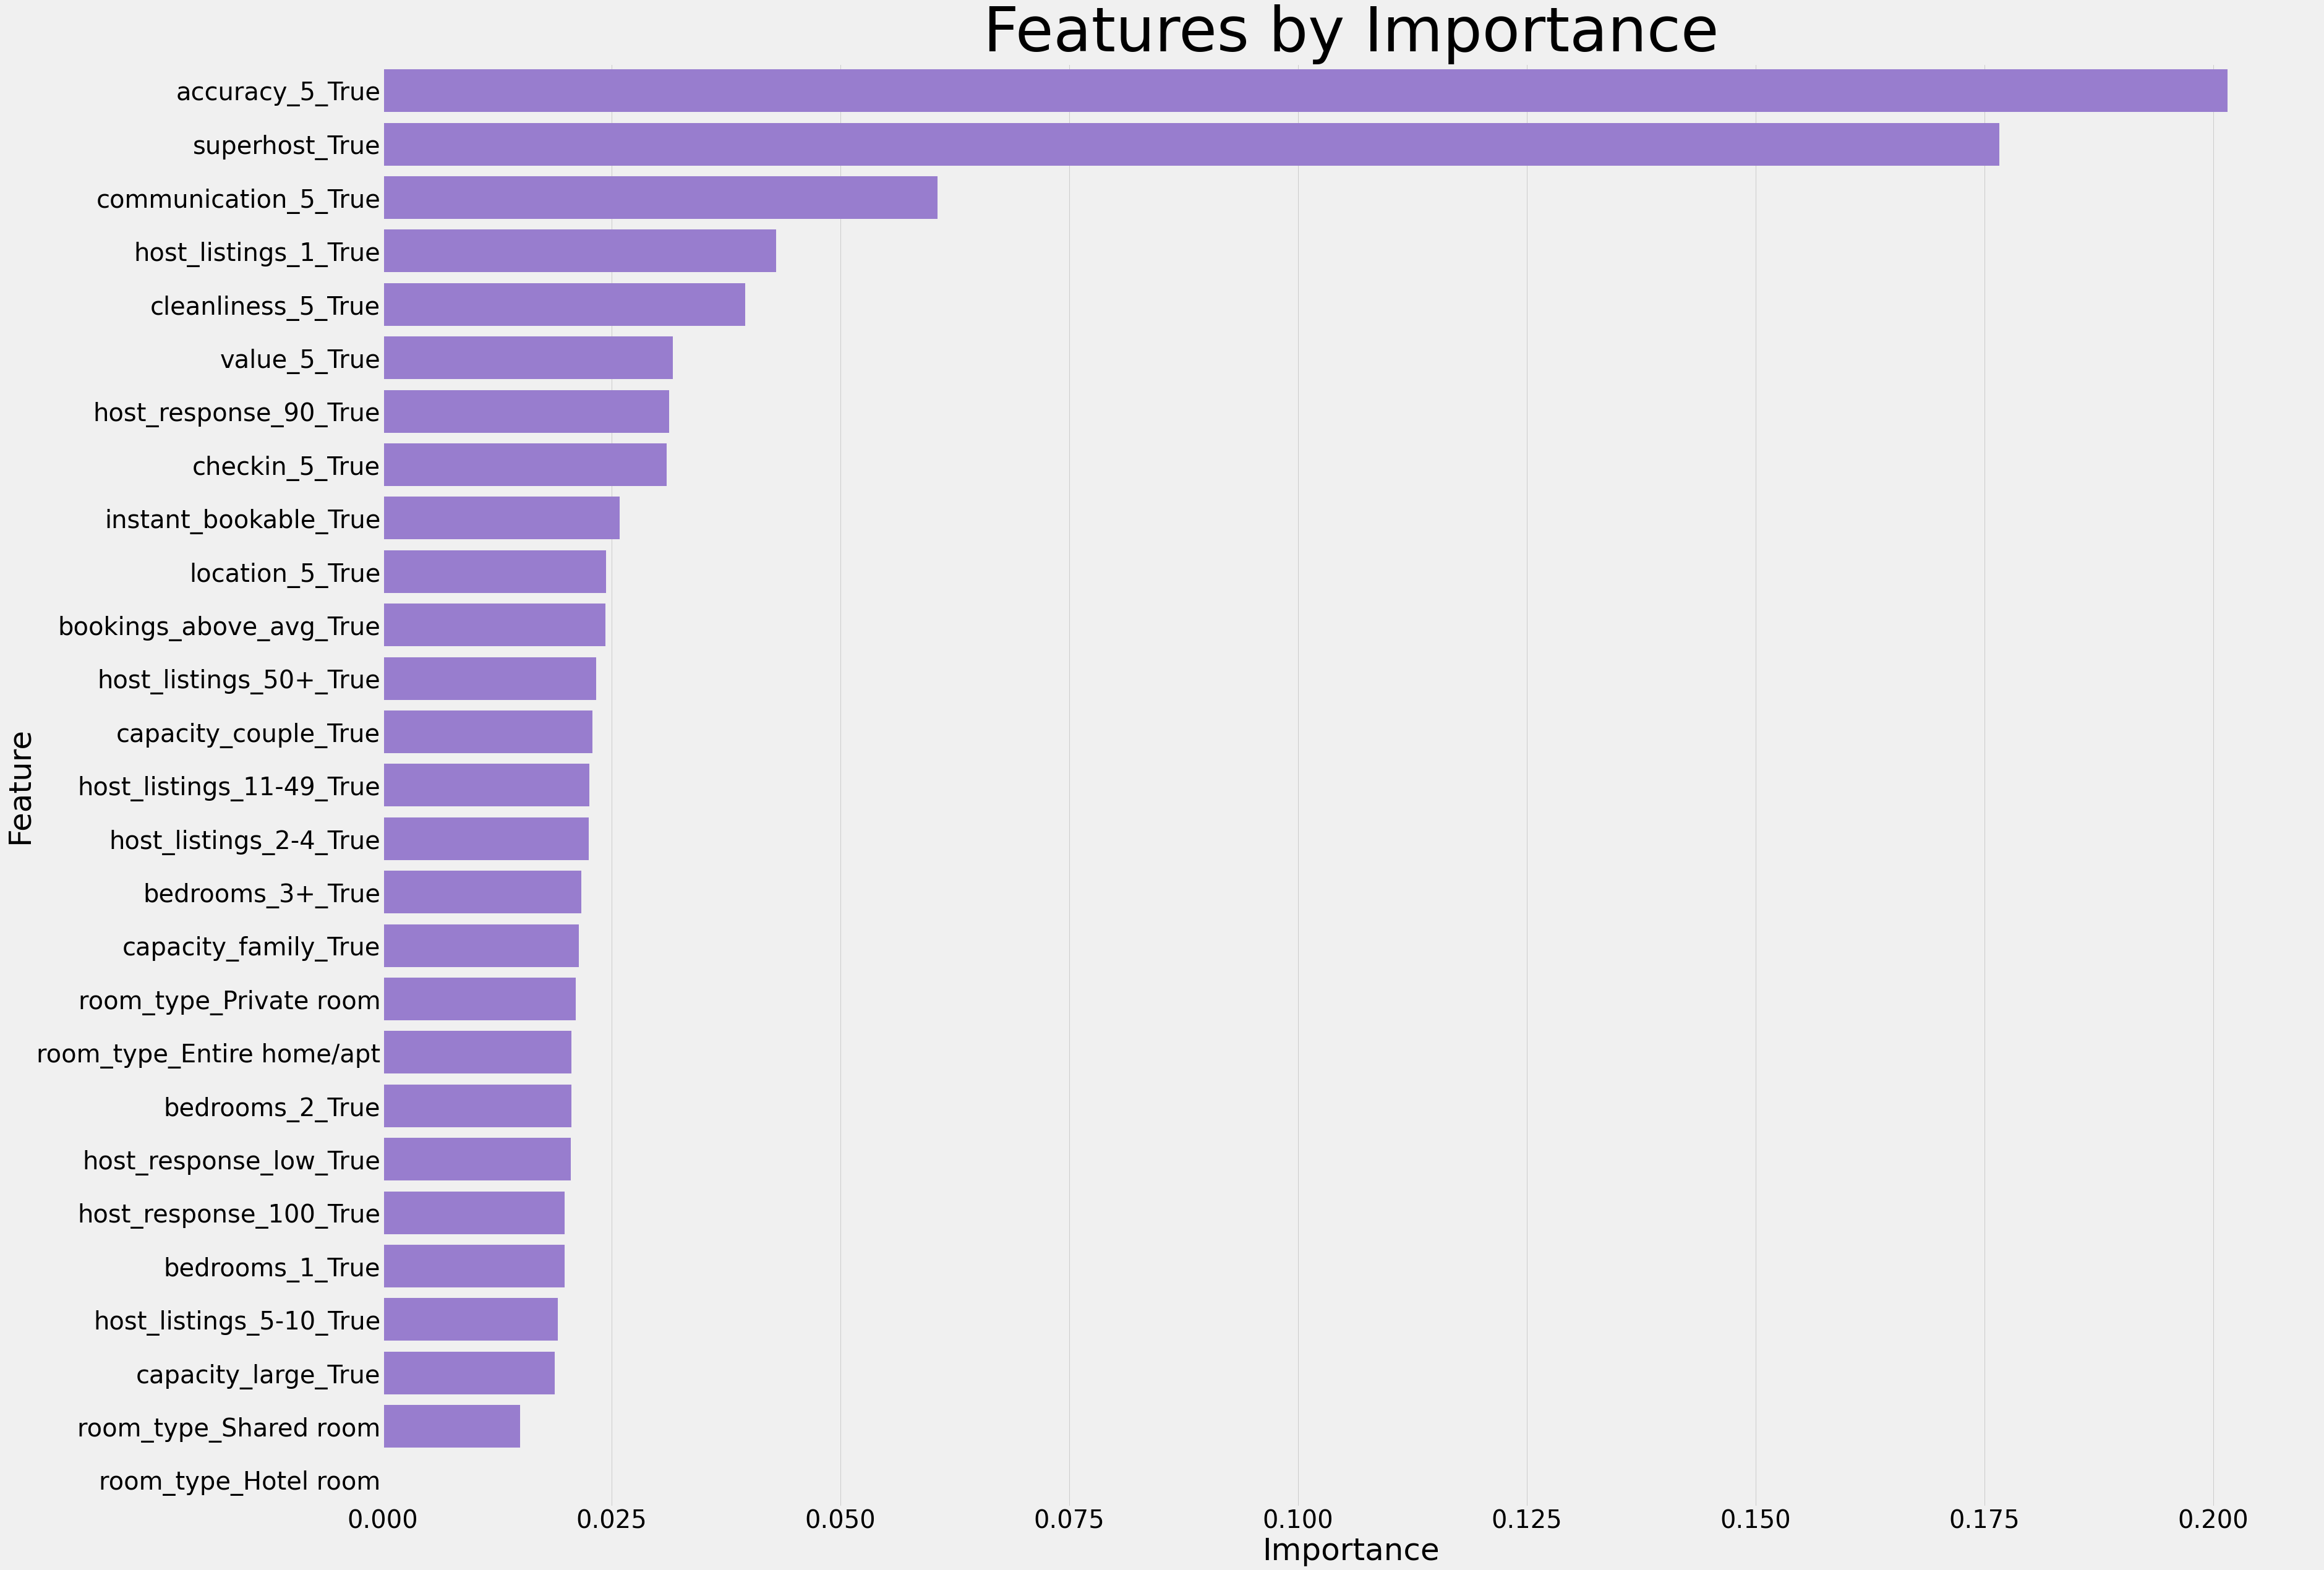

In [148]:
# plot feature importance
fig, ax = plt.subplots(figsize=(50,40))
p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumpurple' );
p.set_xlabel("Importance", fontsize = 50)

p.set_ylabel("Feature", fontsize = 50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Features by Importance", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

In [150]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7810 entries, 0 to 10933
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           7810 non-null   float64
 1   review_scores_rating            7810 non-null   float64
 2   review_scores_accuracy          7810 non-null   float64
 3   review_scores_cleanliness       7810 non-null   float64
 4   review_scores_checkin           7810 non-null   float64
 5   review_scores_communication     7810 non-null   float64
 6   review_scores_location          7810 non-null   float64
 7   review_scores_value             7810 non-null   float64
 8   accommodates                    7810 non-null   int64  
 9   bedrooms                        7810 non-null   float64
 10  beds                            7810 non-null   float64
 11  instant_bookable                7810 non-null   bool   
 12  property_type                   7

## <b>Review Metric DF (or Feature Analysis DF)</b>

In [151]:
review_metrics = df[['5_star', 'accuracy_5', 'communication_5','cleanliness_5', 'checkin_5', 'location_5',
                     'value_5', 'superhost', 'host_listings_1', 'host_listings_2-4', 'host_listings_5-10',
                     'host_listings_11-49', 'host_listings_50+','instant_bookable', 'bookings_above_avg', 
                     'capacity_couple', 'capacity_family', 'capacity_large', 'host_response_100', 
                     'host_response_90', 'host_response_low', 'room_type', 'host_response_time',
                     'bedrooms_1', 'bedrooms_2', 'bedrooms_3+']]

In [152]:
#old one

#review_metrics = df[['5_star', 'accuracy_5', 'communication_5','cleanliness_5', 'checkin_5', 'location_5',
#                     'value_5', 'superhost', 'host_listings_5+', 'instant_bookable', 'booked', 
#                     'capacity_couple', 'capacity_family', 'capacity_large', 'host_response_100',
#                     'room_type', 'host_response_time','bedrooms_1']]

In [153]:
review_metrics.head(2)

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_1,host_listings_2-4,...,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,room_type,host_response_time,bedrooms_1,bedrooms_2,bedrooms_3+
0,True,True,True,True,True,False,True,False,True,False,...,False,True,True,False,False,Private room,within an hour,True,False,False
1,True,False,False,False,False,False,False,True,False,True,...,False,False,True,False,False,Entire home/apt,within an hour,False,False,True


In [ ]:
#review_metrics['instant_bookable'] = review_metrics['instant_bookable'].astype('bool')
#review_metrics['host_is_superhost'] = review_metrics['host_is_superhost'].astype('bool')

In [154]:
review_metrics['instant_bookable'].value_counts()

False    4114
True     3696
Name: instant_bookable, dtype: int64

## Function get_stats( )

In [155]:
def get_stats(df):
    
    df_transposed = df.transpose()
    df_transposed = df_transposed.reset_index()
    df_transposed.rename(columns={'index': 'Metric'}, inplace=True)
    stats_df = df_transposed
    total = stats_df.apply(lambda x: x[False] + x[True], axis=1)
    stats_df['total'] = total
    #difference = stats_df.apply(lambda x: x[True] - x[False], axis=1)
    #stats_df['diff'] = difference
    #percent_difference = stats_df.apply(lambda x: x['diff'] / x['total'], axis=1)
    #stats_df['diff_percent'] = percent_difference
    true = stats_df.apply(lambda x: x[True] / x['total'], axis=1)
    stats_df['%_True'] = true*100
    false = stats_df.apply(lambda x: x[False] / x['total'], axis=1)
    stats_df['%_False'] = false*100
    delta = stats_df.apply(lambda x: x['%_True'] - x['%_False'], axis=1)
    stats_df['delta'] = delta
         
    return stats_df. sort_values('delta', ascending=False)

In [156]:
def plot_stats(df):
    
    fig, ax = plt.subplots(figsize=(50,20))
    p = sns.barplot(data=df, x='Metric', y='delta', color ='seagreen' );
    #p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

    p.set_xlabel("Feature", fontsize = 50)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=40)

    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

    p.set_title("Difference Between Features ", fontsize = 100)
    plt.figsize=(30,20) 

    return plt.show();

In [157]:
review_metrics.describe()

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_1,host_listings_2-4,...,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,room_type,host_response_time,bedrooms_1,bedrooms_2,bedrooms_3+
count,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810,...,7810,7810,7810,7810,7810,7810,7810,7810,7810,7810
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,4,4,2,2,2
top,True,False,False,False,False,False,False,True,False,False,...,False,True,True,False,False,Entire home/apt,within an hour,False,False,False
freq,4918,5806,5035,5981,5084,5434,6579,3999,5369,5645,...,7365,4653,5721,6323,7208,6487,6229,4231,5638,5751


### <b>Top Feature #1: SuperHost</b>

In [158]:
review_metrics['superhost'].value_counts()

True     3999
False    3811
Name: superhost, dtype: int64

In [189]:
superhost_metrics = review_metrics.groupby('superhost').sum()
superhost_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,host_listings_5-10,host_listings_11-49,host_listings_50+,...,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+,host_listings_low
superhost,,,,,,,,,,,,,,,,,,,,,
False,1671,1132,1394,1036,1432,1416,814,480,875,473,...,920,212,2200,2461,811,539,1662,1100,1049,1983
True,3247,872,1381,793,1294,960,417,569,508,299,...,1088,233,2453,3260,676,63,1917,1072,1010,2623


In [190]:
superhost_stats = get_stats(superhost_metrics)
superhost_stats

superhost,Metric,False,True,total,%_True,%_False,delta
0,5_star,1671,3247,4918,66.022773,33.977227,32.045547
15,host_response_100,2461,3260,5721,56.983045,43.016955,13.966090
21,host_listings_low,1983,2623,4606,56.947460,43.052540,13.894920
11,bookings_above_avg,1804,2274,4078,55.762629,44.237371,11.525257
7,host_listings_5-10,480,569,1049,54.242135,45.757865,8.484271
12,capacity_couple,920,1088,2008,54.183267,45.816733,8.366534
18,bedrooms_1,1662,1917,3579,53.562448,46.437552,7.124895
14,capacity_large,2200,2453,4653,52.718676,47.281324,5.437352
13,capacity_family,212,233,445,52.359551,47.640449,4.719101
2,communication_5,1394,1381,2775,49.765766,50.234234,-0.468468


#### Analysis: 
- Superhosts have a more success in getting their units booked than non-superhosts. But it is just a 10.5% increase.
- They also have a much higher response rate than non-superhosts. Since this is a requirement of the superhost program, this isn't a surprise.
- There isn't much of a difference in the communication level of superhosts and non-superhosts.
- For most review metrics, Superhosts have a <b> lower </b> average rate than those of non-superhosts. Esecially in Value.

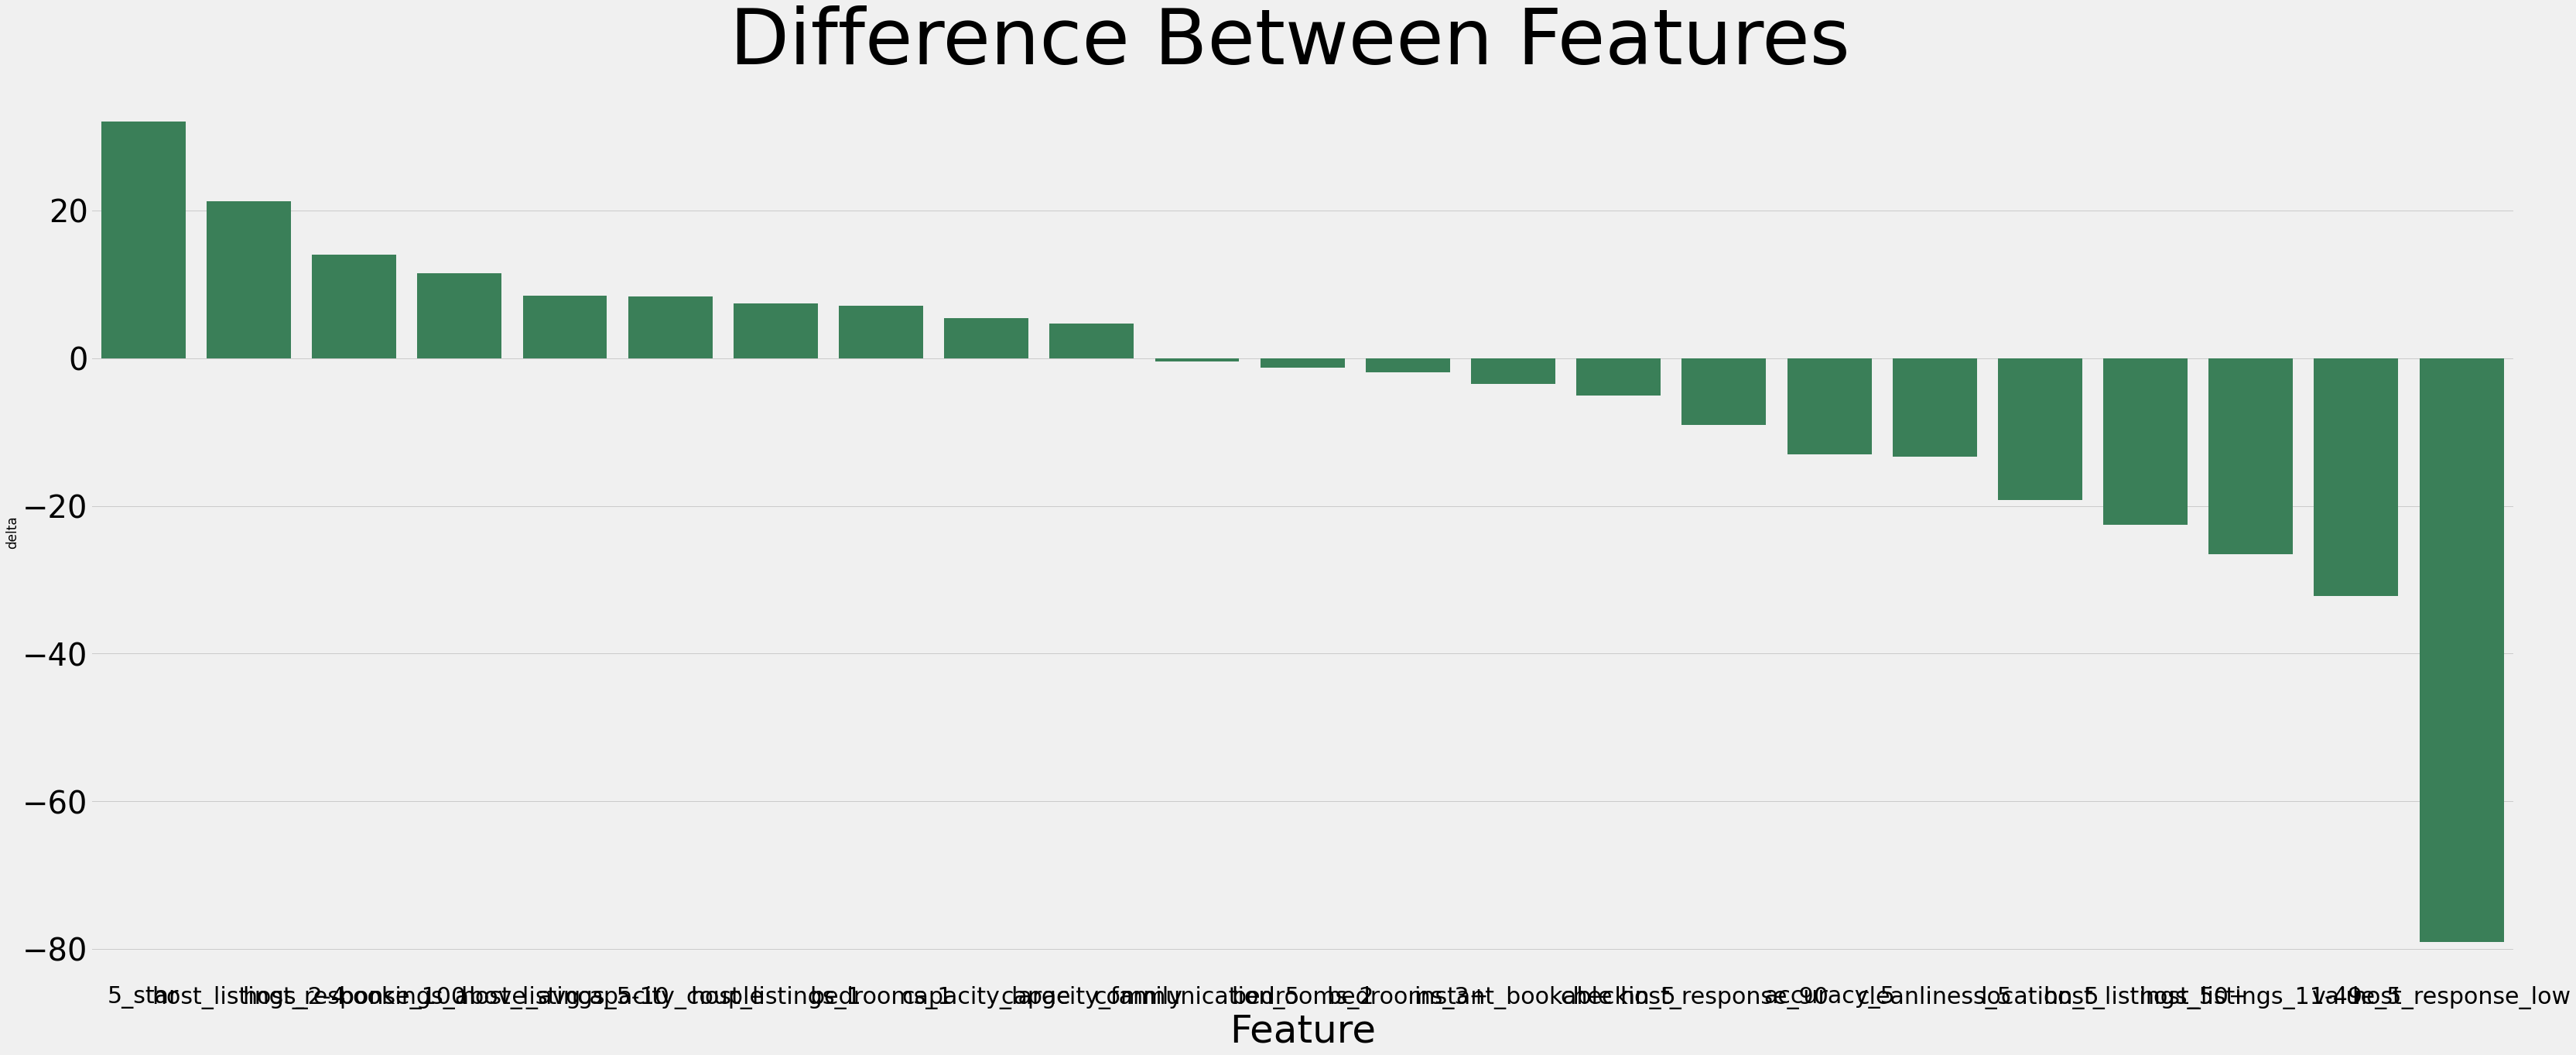

In [161]:
superhost_plot = plot_stats(superhost_stats)
superhost_plot

In [162]:
double_group = review_metrics.groupby(['superhost', '5_star']).sum()
double_group

accuracy_5  communication_5  cleanliness_5  checkin_5  \
superhost 5_star                                                          
False     False          148              296            151        351   
          True           984             1098            885       1081   
True      False           53              148             70        137   
          True           819             1233            723       1157   

                  location_5  value_5  host_listings_1  host_listings_2-4  \
superhost 5_star                                                            
False     False          390       77              429                493   
          True          1026      737              701                360   
True      False          130       19              123                223   
          True           830      398             1188               1089   

                  host_listings_5-10  host_listings_11-49  ...  \
superhost 5_star                                           ...   
False     False                  333                  599  ...   
          True                   147                  276  ...   
True      False                  133                  156  ...   
          True                   436                  352  ...   

                  bookings_above_avg  capacity_couple  capacity_family  \
superhost 5_star                                                         
False     False                  914              420              118   
          True                   890              500               94   
True      False                  359              155               40   
          True                  1915              933              193   

                  capacity_large  host_response_100  host_response_90  \
superhost 5_star                                                        
False     False             1201               1336               535   
          True               999               1125               276   
True      False              427                516               226   
          True              2026               2744               450   

                  host_response_low  bedrooms_1  bedrooms_2  bedrooms_3+  
superhost 5_star                                                          
False     False                 269         912         688          540  
          True                  270         750         412          509  
True      False                  10         331         233          188  
          True                   53        1586         839          822  

[4 rows x 22 columns]

In [163]:
df_transposed = double_group.transpose()
df_transposed = df_transposed.reset_index()
df_transposed.rename(columns={'index': 'Metric'}, inplace=True)
df_transposed

superhost               Metric False        True      
5_star                         False  True False  True
0                   accuracy_5   148   984    53   819
1              communication_5   296  1098   148  1233
2                cleanliness_5   151   885    70   723
3                    checkin_5   351  1081   137  1157
4                   location_5   390  1026   130   830
5                      value_5    77   737    19   398
6              host_listings_1   429   701   123  1188
7            host_listings_2-4   493   360   223  1089
8           host_listings_5-10   333   147   133   436
9          host_listings_11-49   599   276   156   352
10           host_listings_50+   286   187   117   182
11            instant_bookable  1242   670   400  1384
12          bookings_above_avg   914   890   359  1915
13             capacity_couple   420   500   155   933
14             capacity_family   118    94    40   193
15              capacity_large  1201   999   427  2026
16           host_response_100  1336  1125   516  2744
17            host_response_90   535   276   226   450
18           host_response_low   269   270    10    53
19                  bedrooms_1   912   750   331  1586
20                  bedrooms_2   688   412   233   839
21                 bedrooms_3+   540   509   188   822

### <b> Top Feature #1: Accuracy </b>

In [164]:
accuracy_metrics = review_metrics.groupby('accuracy_5').sum()
accuracy_metrics

,5_star,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_1,host_listings_2-4,host_listings_5-10,...,bookings_above_avg,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+
accuracy_5,,,,,,,,,,,,,,,,,,,,,
False,3115,1102,490,1110,943,167,3127,1650,1644,842,...,3041,1418,332,3439,4282,1145,379,2697,1669,1440
True,1803,1673,1339,1616,1433,1064,872,791,521,207,...,1037,590,113,1214,1439,342,223,882,503,619


In [165]:
accuracy_stats = get_stats(accuracy_metrics)
accuracy_stats

accuracy_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,167,1064,1231,86.433794,13.566206,72.867587
2,cleanliness_5,490,1339,1829,73.209404,26.790596,46.418808
4,location_5,943,1433,2376,60.311448,39.688552,20.622896
1,communication_5,1102,1673,2775,60.288288,39.711712,20.576577
3,checkin_5,1110,1616,2726,59.280998,40.719002,18.561996
19,host_response_low,379,223,602,37.043189,62.956811,-25.913621
0,5_star,3115,1803,4918,36.661244,63.338756,-26.677511
7,host_listings_1,1650,791,2441,32.404752,67.595248,-35.190496
11,host_listings_50+,538,234,772,30.310881,69.689119,-39.378238
22,bedrooms_3+,1440,619,2059,30.063137,69.936863,-39.873725


#### Analysis: 
- The biggest difference between clients with a perfect accuracy score is that most also had a high <b> value</b> score. (72.8%)
- The next biggest difference was cleanliness. 
- The next step down was communication, checking ,and location.
- Notably, clients with high accuracy scores are significantly less likely to be a superhost, have 5 or more listings, or utilize the instant book feature.

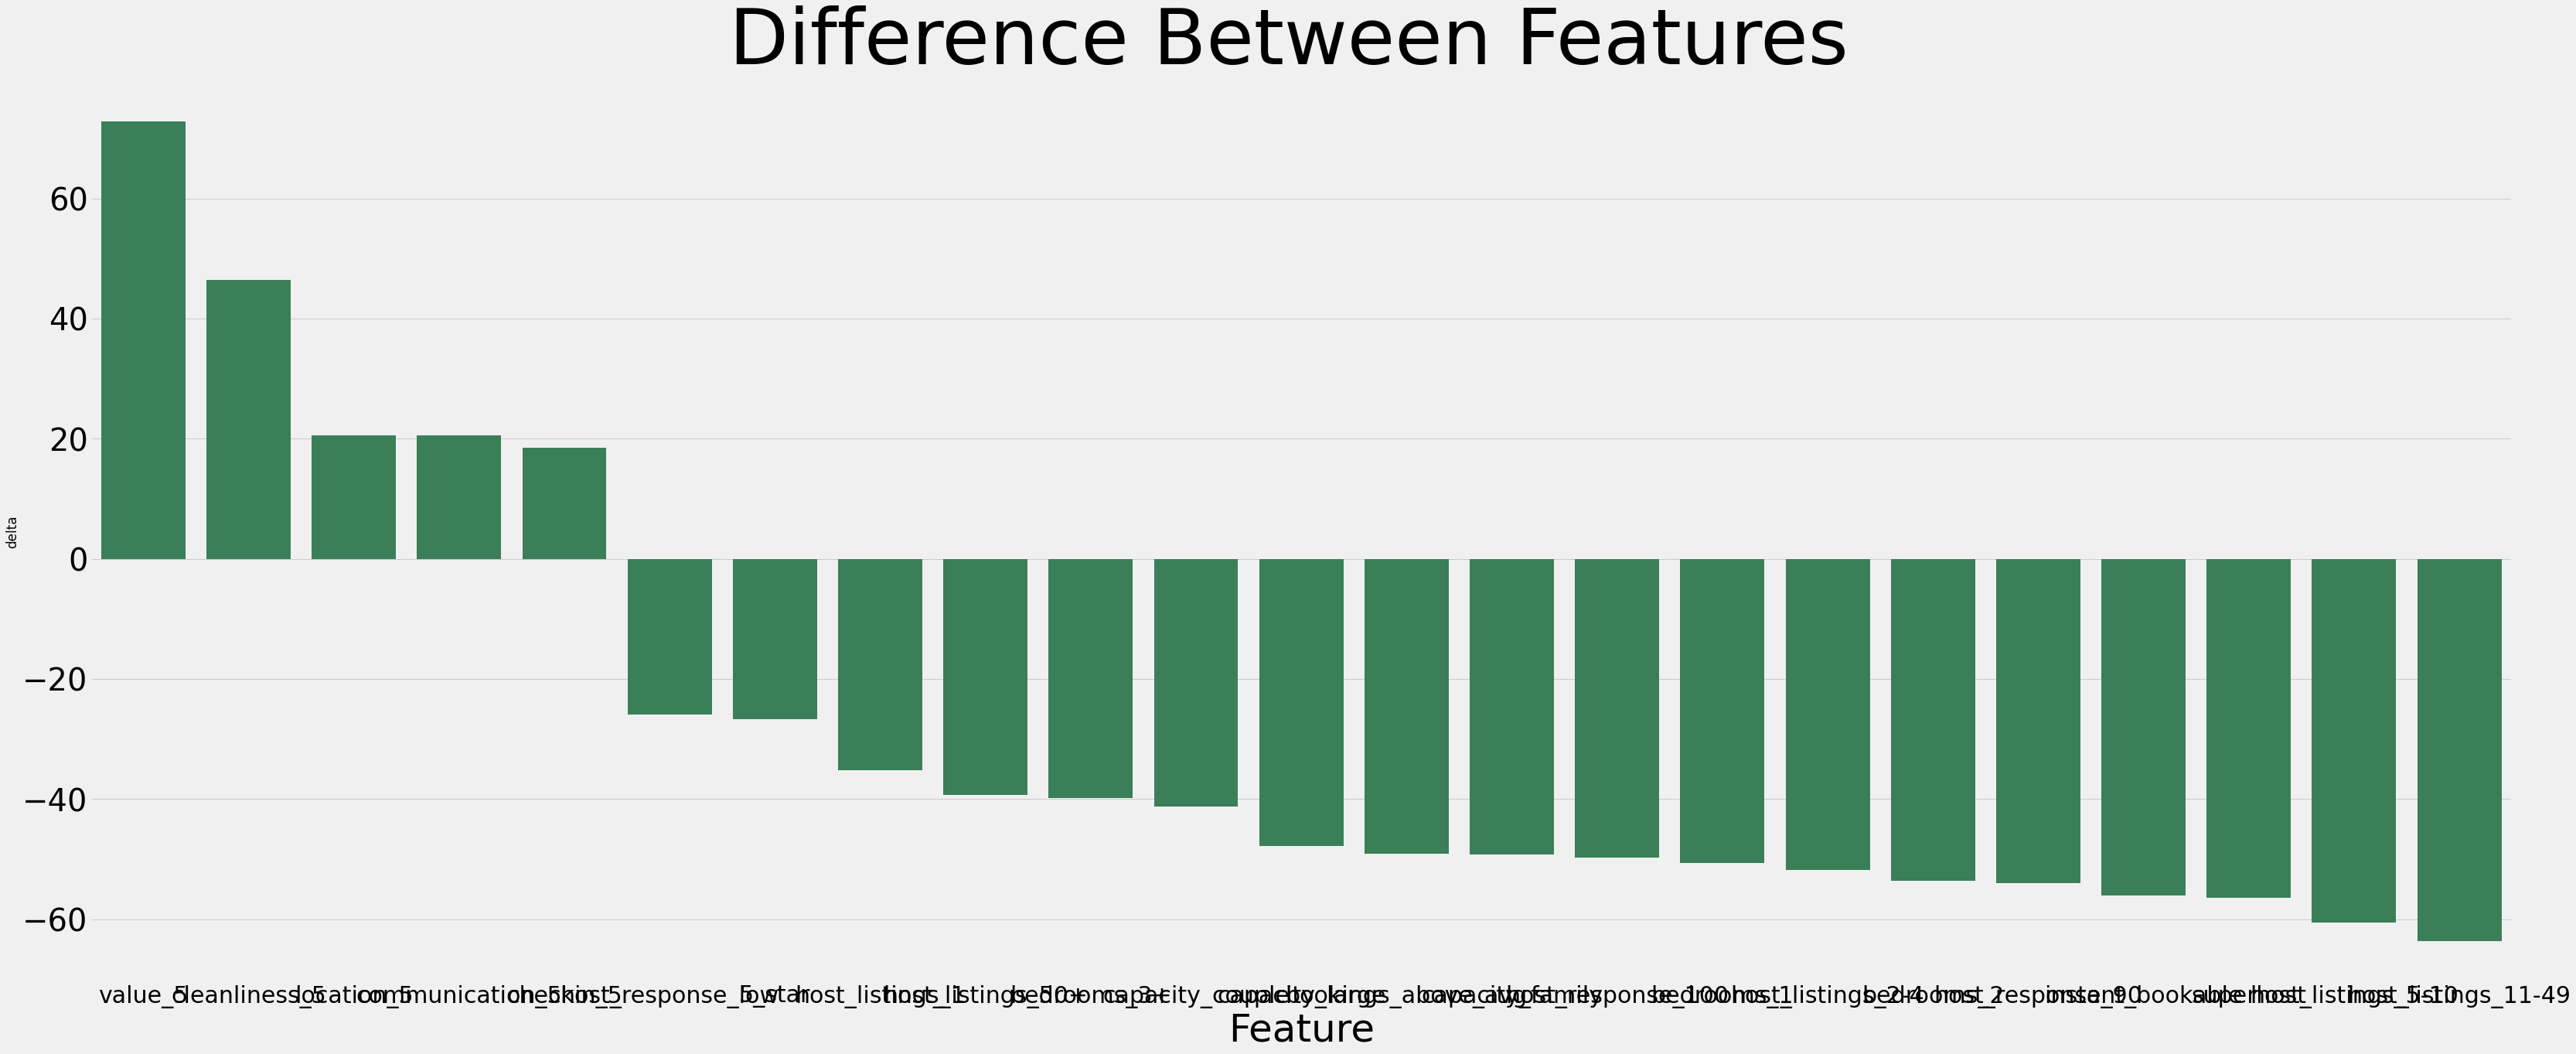

In [166]:
accuracy_plot = plot_stats(accuracy_stats)
accuracy_plot

### <b> Top Feature #2: Communication</b>

In [167]:
communication_metrics = review_metrics.groupby('communication_5').sum()
communication_metrics

,5_star,accuracy_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_1,host_listings_2-4,host_listings_5-10,...,bookings_above_avg,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+
communication_5,,,,,,,,,,,,,,,,,,,,,
False,2587,331,359,615,680,114,2618,1348,1431,747,...,2582,1225,281,3002,3643,1046,346,2364,1438,1233
True,2331,1673,1470,2111,1696,1117,1381,1093,734,302,...,1496,783,164,1651,2078,441,256,1215,734,826


In [168]:
communication_stats = get_stats(communication_metrics)
communication_stats

communication_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,114,1117,1231,90.739236,9.260764,81.478473
1,accuracy_5,331,1673,2004,83.483034,16.516966,66.966068
2,cleanliness_5,359,1470,1829,80.371788,19.628212,60.743576
3,checkin_5,615,2111,2726,77.439472,22.560528,54.878944
4,location_5,680,1696,2376,71.380471,28.619529,42.760943
0,5_star,2587,2331,4918,47.397316,52.602684,-5.205368
7,host_listings_1,1348,1093,2441,44.776731,55.223269,-10.446538
19,host_response_low,346,256,602,42.524917,57.475083,-14.950166
22,bedrooms_3+,1233,826,2059,40.116561,59.883439,-19.766877
14,capacity_couple,1225,783,2008,38.994024,61.005976,-22.011952


####  Analysis: 
- Clients that communicate well have significantly better value and accuracy scores than those who don't. 
- It's also noticeable that clients who scored high in communication had under 5 listings, and were less likely to use instant book for their property.
-- My assumption is that they prefer a more "hands on" approach and want to make sure that they are communicating directly to the person booking the property than having the process automated and unpersonalized.

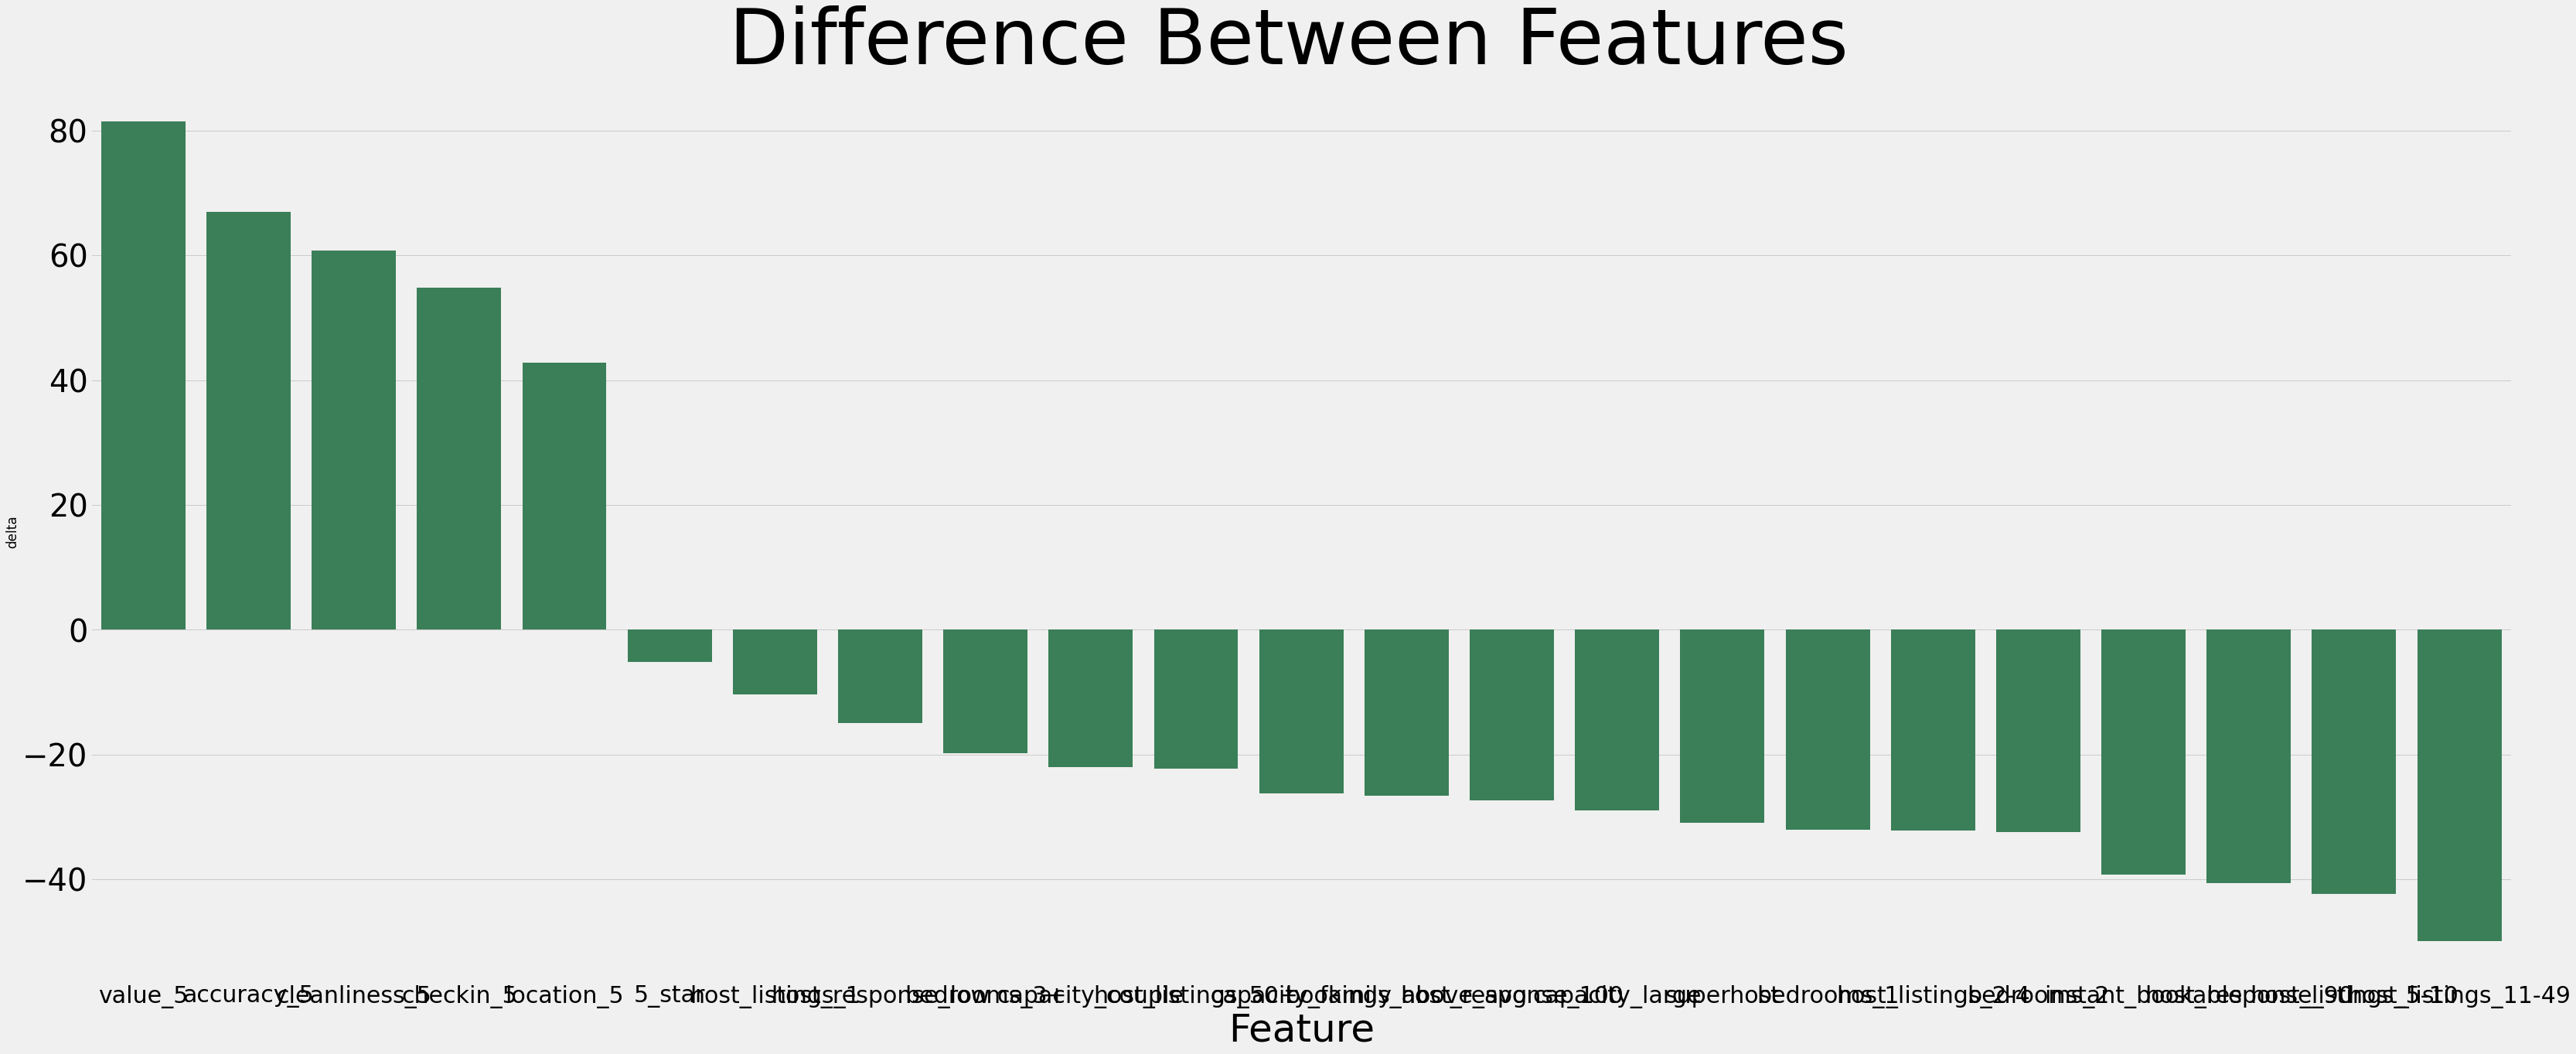

In [169]:
communication_plot = plot_stats(communication_stats)
communication_plot

### Top Feature # Check-in

In [170]:
checkin_metrics = review_metrics.groupby('checkin_5').sum()
checkin_stats = get_stats(checkin_metrics)
checkin_stats

checkin_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,127,1104,1231,89.683184,10.316816,79.366369
1,accuracy_5,388,1616,2004,80.638723,19.361277,61.277445
3,cleanliness_5,373,1456,1829,79.606342,20.393658,59.212685
2,communication_5,664,2111,2775,76.072072,23.927928,52.144144
4,location_5,697,1679,2376,70.664983,29.335017,41.329966
19,host_response_low,323,279,602,46.345515,53.654485,-7.308970
0,5_star,2680,2238,4918,45.506303,54.493697,-8.987393
7,host_listings_1,1380,1061,2441,43.465793,56.534207,-13.068415
22,bedrooms_3+,1223,836,2059,40.602234,59.397766,-18.795532
11,host_listings_50+,463,309,772,40.025907,59.974093,-19.948187


### <b> Top Feature #4: Value</b>

In [171]:
value_metrics = review_metrics.groupby('value_5').sum()
value_stats = get_stats(value_metrics)
value_stats

value_5,Metric,False,True,total,%_True,%_False,delta
3,cleanliness_5,854,975,1829,53.307818,46.692182,6.615637
1,accuracy_5,940,1064,2004,53.093812,46.906188,6.187625
5,location_5,1340,1036,2376,43.602694,56.397306,-12.794613
4,checkin_5,1622,1104,2726,40.498899,59.501101,-19.002201
2,communication_5,1658,1117,2775,40.252252,59.747748,-19.495495
19,host_response_low,435,167,602,27.740864,72.259136,-44.518272
0,5_star,3783,1135,4918,23.078487,76.921513,-53.843026
14,capacity_couple,1589,419,2008,20.866534,79.133466,-58.266932
7,host_listings_1,1959,482,2441,19.746006,80.253994,-60.507989
16,capacity_large,3872,781,4653,16.784870,83.215130,-66.430260


### <b> Top Feature #5: # of Host Listings: </b>

In [179]:
review_metrics['host_listings_low'].value_counts()

True     4606
False    3204
Name: host_listings_low, dtype: int64

In [184]:
review_metrics.drop(['host_listings_1', 'host_listings_2-4'], axis=1, inplace=True)

In [185]:
host_listing_metrics = review_metrics.groupby('host_listings_low').sum()
get_stats(host_listing_metrics)

host_listings_low,Metric,False,True,total,%_True,%_False,delta
13,capacity_couple,455,1553,2008,77.340637,22.659363,54.681275
14,capacity_family,137,308,445,69.213483,30.786517,38.426966
0,5_star,1580,3338,4918,67.873119,32.126881,35.746238
16,host_response_100,1867,3854,5721,67.365845,32.634155,34.731690
12,bookings_above_avg,1345,2733,4078,67.018146,32.981854,34.036292
15,capacity_large,1564,3089,4653,66.387277,33.612723,32.774554
19,bedrooms_1,1215,2364,3579,66.051970,33.948030,32.103940
6,value_5,418,813,1231,66.043867,33.956133,32.087734
2,communication_5,948,1827,2775,65.837838,34.162162,31.675676
7,superhost,1376,2623,3999,65.591398,34.408602,31.182796


#### Analysis

### Cleanliness Stats

In [186]:
cleanliness_metrics = review_metrics.groupby('cleanliness_5').mean()
cleanliness_metrics

,5_star,accuracy_5,communication_5,checkin_5,location_5,value_5,superhost,host_listings_5-10,host_listings_11-49,host_listings_50+,...,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+,host_listings_low
cleanliness_5,,,,,,,,,,,,,,,,,,,,,
False,0.553419,0.111185,0.218191,0.212339,0.185420,0.042802,0.536031,0.140612,0.189099,0.092292,...,0.243103,0.058184,0.593881,0.738840,0.197291,0.063869,0.461628,0.285571,0.252801,0.577997
True,0.879169,0.732094,0.803718,0.796063,0.692728,0.533078,0.433570,0.113723,0.137780,0.120284,...,0.302898,0.053034,0.601968,0.711864,0.167851,0.120284,0.447239,0.253691,0.299071,0.628212


In [187]:
cleanliness_stats = get_stats(cleanliness_metrics)
cleanliness_stats

cleanliness_5,Metric,False,True,total,%_True,%_False,delta
5,value_5,0.042802,0.533078,0.575880,92.567518,7.432482,85.135036
1,accuracy_5,0.111185,0.732094,0.843279,86.815116,13.184884,73.630232
3,checkin_5,0.212339,0.796063,1.008402,78.943024,21.056976,57.886048
4,location_5,0.185420,0.692728,0.878149,78.885070,21.114930,57.770140
2,communication_5,0.218191,0.803718,1.021909,78.648688,21.351312,57.297376
17,host_response_low,0.063869,0.120284,0.184153,65.317513,34.682487,30.635027
0,5_star,0.553419,0.879169,1.432588,61.369276,38.630724,22.738551
9,host_listings_50+,0.092292,0.120284,0.212577,56.583992,43.416008,13.167985
12,capacity_couple,0.243103,0.302898,0.546001,55.475687,44.524313,10.951373
20,bedrooms_3+,0.252801,0.299071,0.551871,54.192102,45.807898,8.384204


### Analysis
- Clients that have a perfect cleanliness score score high in all the other review metrics, most notably Value, and Accuracy.
- However, the bigger factors are that they aren't likely to manage 5 or more listings, be instant bookable, or a superhost.
-- My assumption is that they can keep their rental(s) clean because they don't have more than they can handle, and they 

In [ ]:
cleanliness_plot = plot_stats(cleanliness_stats)
cleanliness_plot

### <b> 5 Star Unit Stats </b>

In [191]:
five_star_metrics = review_metrics.groupby('5_star').sum()
five_star_metrics

,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5-10,host_listings_11-49,host_listings_50+,...,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+,host_listings_low
5_star,,,,,,,,,,,,,,,,,,,,,
False,201,444,221,488,520,96,752,466,755,403,...,575,158,1628,1852,761,279,1243,921,728,1268
True,1803,2331,1608,2238,1856,1135,3247,583,628,369,...,1433,287,3025,3869,726,323,2336,1251,1331,3338


In [192]:
five_star_stats = get_stats(five_star_metrics)
five_star_stats

5_star,Metric,False,True,total,%_True,%_False,delta
5,value_5,96,1135,1231,92.201462,7.798538,84.402924
0,accuracy_5,201,1803,2004,89.970060,10.029940,79.940120
2,cleanliness_5,221,1608,1829,87.916894,12.083106,75.833789
1,communication_5,444,2331,2775,84.000000,16.000000,68.000000
3,checkin_5,488,2238,2726,82.098313,17.901687,64.196625
6,superhost,752,3247,3999,81.195299,18.804701,62.390598
4,location_5,520,1856,2376,78.114478,21.885522,56.228956
21,host_listings_low,1268,3338,4606,72.470690,27.529310,44.941381
12,capacity_couple,575,1433,2008,71.364542,28.635458,42.729084
11,bookings_above_avg,1273,2805,4078,68.783718,31.216282,37.567435


### Analysis: 
- 5 Star Overall units score much higher in review metrics. This makes sense because they should have to score high in all of them to get a high overall score (even though it is a seperate metric in terms of AirBnb).
- Noteably, they are significantly less likely to use instant book, have more than 5 listings, or be a superhost.

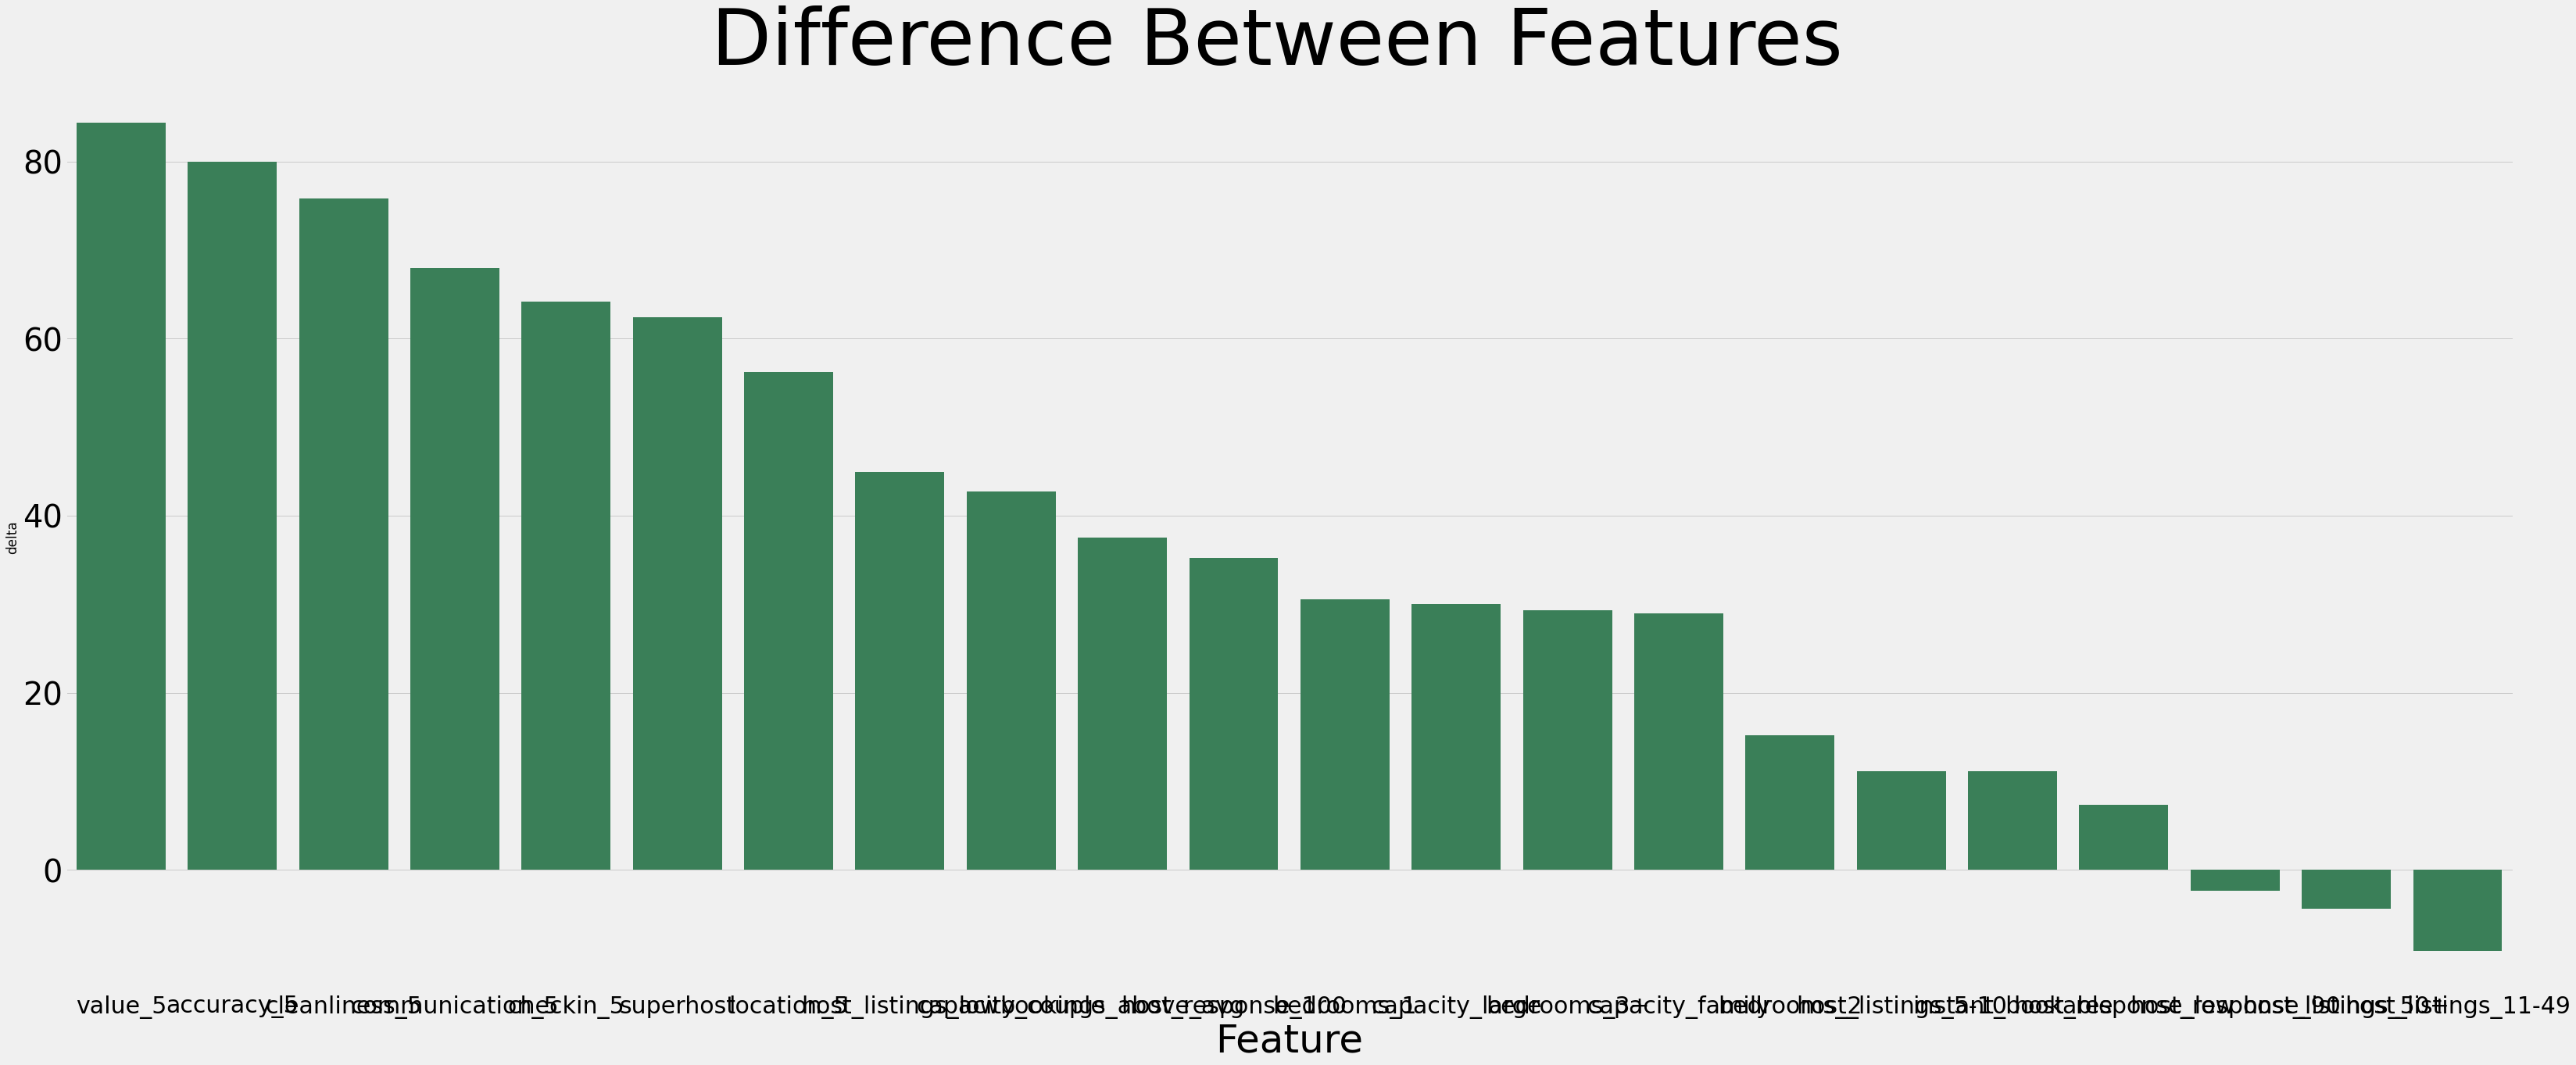

In [193]:
five_star_plot = plot_stats(five_star_stats)
five_star_plot

### Instant Bookable Stats

In [194]:
instant_book_metrics = review_metrics.groupby('instant_bookable').sum()
instant_book_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5-10,host_listings_11-49,...,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+,host_listings_low
instant_bookable,,,,,,,,,,,,,,,,,,,,,
False,2864,1193,1652,1077,1611,1323,736,2215,496,573,...,1325,264,2673,3136,585,393,2042,1081,991,2942
True,2054,811,1123,752,1115,1053,495,1784,553,810,...,683,181,1980,2585,902,209,1537,1091,1068,1664


In [195]:
instant_book_stats = get_stats(instant_book_metrics)
instant_book_stats

instant_bookable,Metric,False,True,total,%_True,%_False,delta
10,host_listings_50+,103,669,772,86.658031,13.341969,73.316062
16,host_response_90,585,902,1487,60.659045,39.340955,21.318090
9,host_listings_11-49,573,810,1383,58.568330,41.431670,17.136659
8,host_listings_5-10,496,553,1049,52.716873,47.283127,5.433746
20,bedrooms_3+,991,1068,2059,51.869840,48.130160,3.739679
19,bedrooms_2,1081,1091,2172,50.230203,49.769797,0.460405
15,host_response_100,3136,2585,5721,45.184408,54.815592,-9.631183
7,superhost,2215,1784,3999,44.611153,55.388847,-10.777694
5,location_5,1323,1053,2376,44.318182,55.681818,-11.363636
18,bedrooms_1,2042,1537,3579,42.944957,57.055043,-14.110087


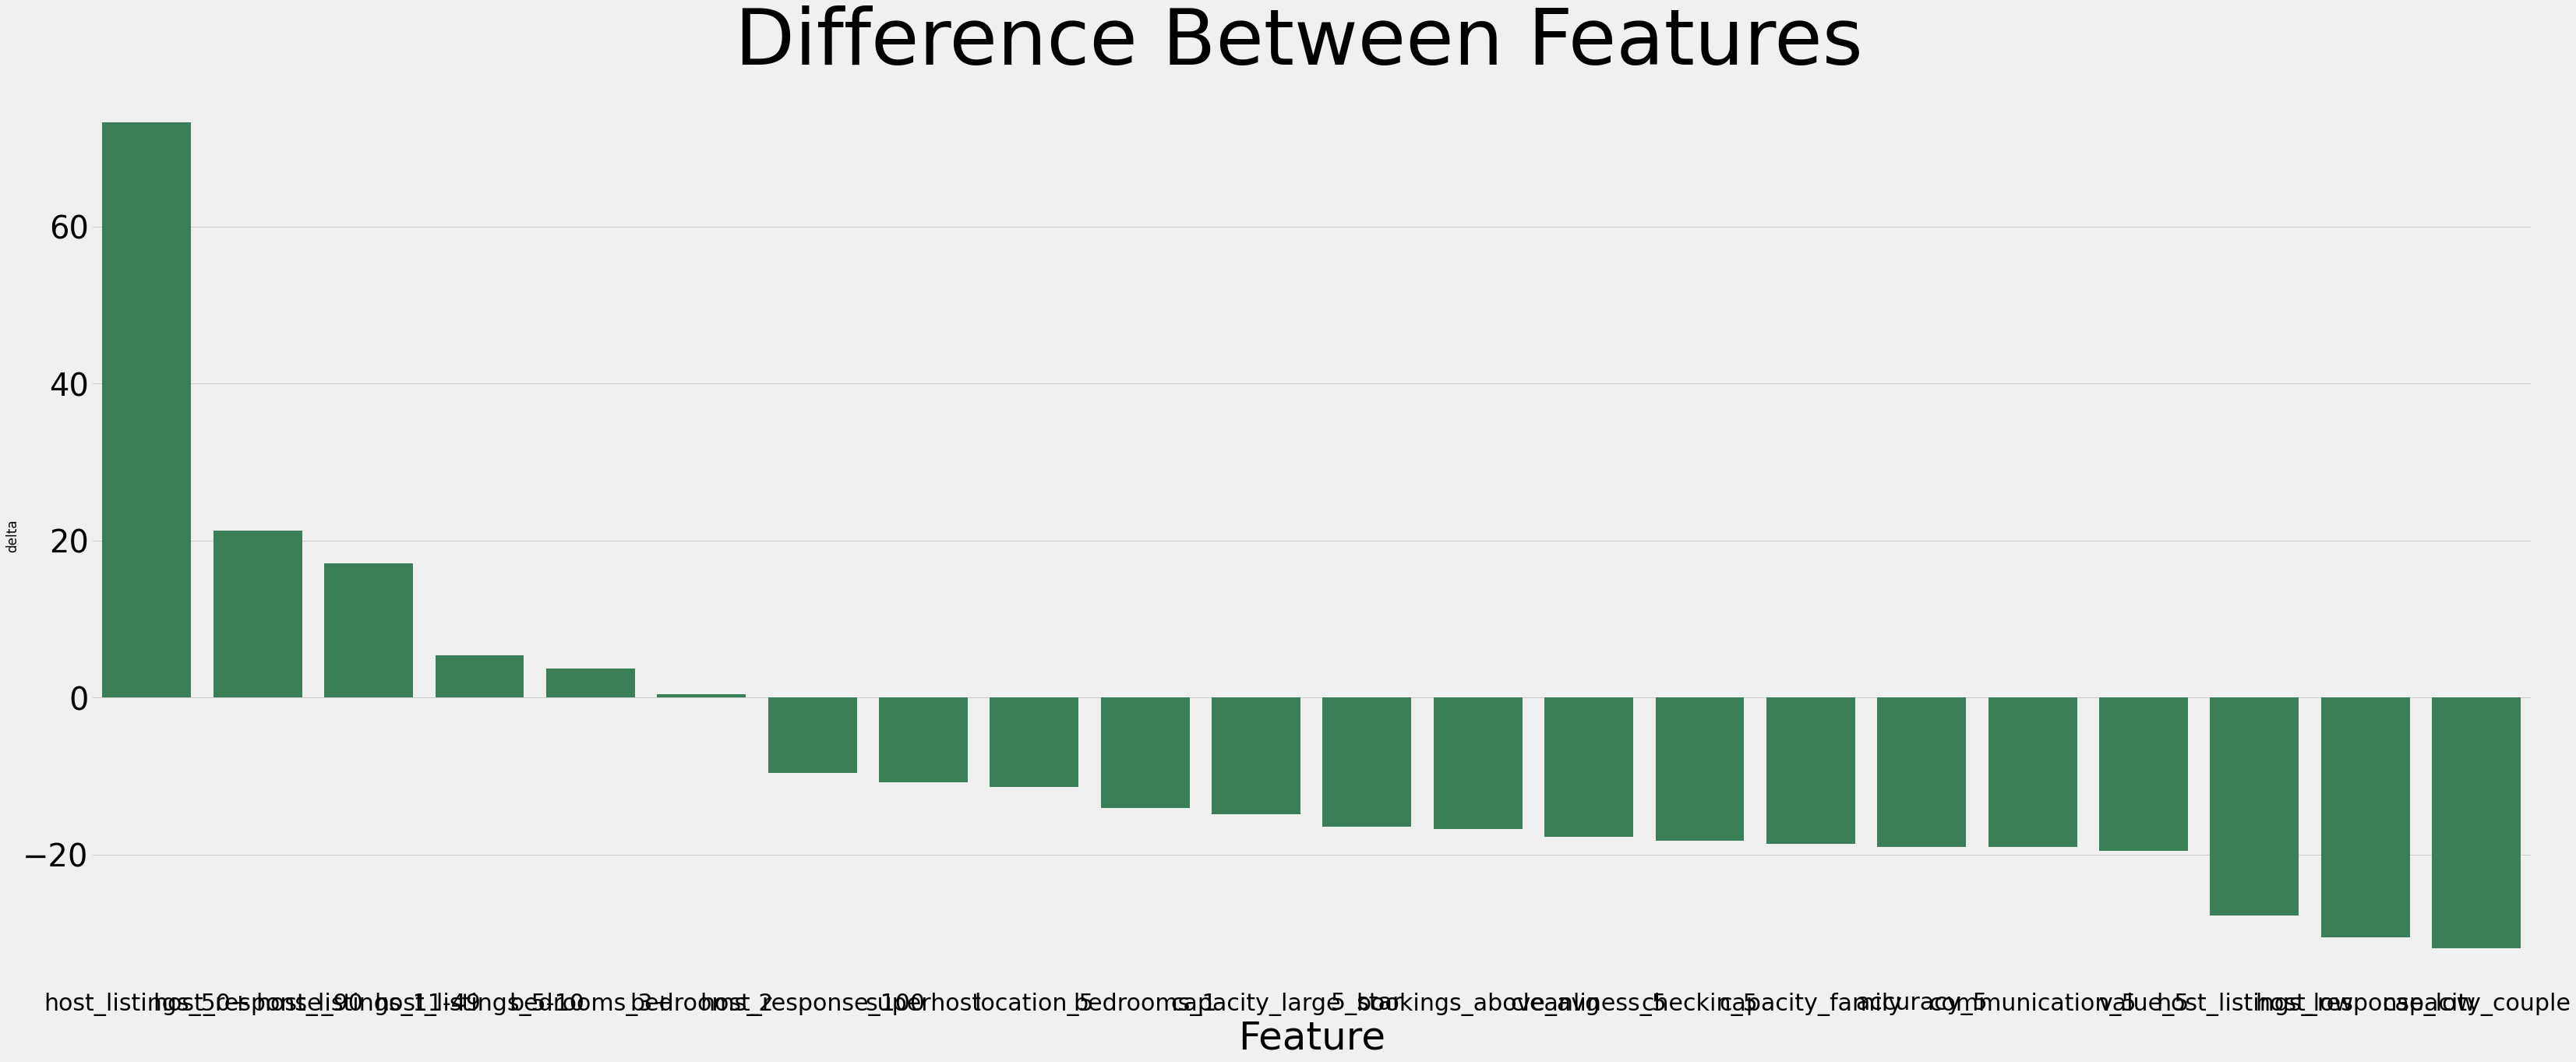

In [196]:
instant_book_plot = plot_stats(instant_book_stats)
instant_book_plot

### Booked Stats

In [197]:
booked_metrics = review_metrics.groupby('bookings_above_avg').sum()
booked_metrics

,5_star,accuracy_5,communication_5,cleanliness_5,checkin_5,location_5,value_5,superhost,host_listings_5-10,host_listings_11-49,...,capacity_couple,capacity_family,capacity_large,host_response_100,host_response_90,host_response_low,bedrooms_1,bedrooms_2,bedrooms_3+,host_listings_low
bookings_above_avg,,,,,,,,,,,,,,,,,,,,,
False,2113,967,1279,913,1275,1141,592,1725,547,752,...,889,203,2085,2596,806,330,1685,984,1063,1873
True,2805,1037,1496,916,1451,1235,639,2274,502,631,...,1119,242,2568,3125,681,272,1894,1188,996,2733


In [198]:
booked_stats = get_stats(booked_metrics)
booked_stats

bookings_above_avg,Metric,False,True,total,%_True,%_False,delta
21,host_listings_low,1873,2733,4606,59.335649,40.664351,18.671298
0,5_star,2113,2805,4918,57.035380,42.964620,14.070760
7,superhost,1725,2274,3999,56.864216,43.135784,13.728432
12,capacity_couple,889,1119,2008,55.727092,44.272908,11.454183
14,capacity_large,2085,2568,4653,55.190200,44.809800,10.380400
19,bedrooms_2,984,1188,2172,54.696133,45.303867,9.392265
15,host_response_100,2596,3125,5721,54.623318,45.376682,9.246635
13,capacity_family,203,242,445,54.382022,45.617978,8.764045
2,communication_5,1279,1496,2775,53.909910,46.090090,7.819820
4,checkin_5,1275,1451,2726,53.228173,46.771827,6.456346


In [ ]:
booked_plot = plot_stats(booked_stats)
booked_plot

In [ ]:
superhost_df = df[df['superhost'] == True]

## Attempting Master LinePlot

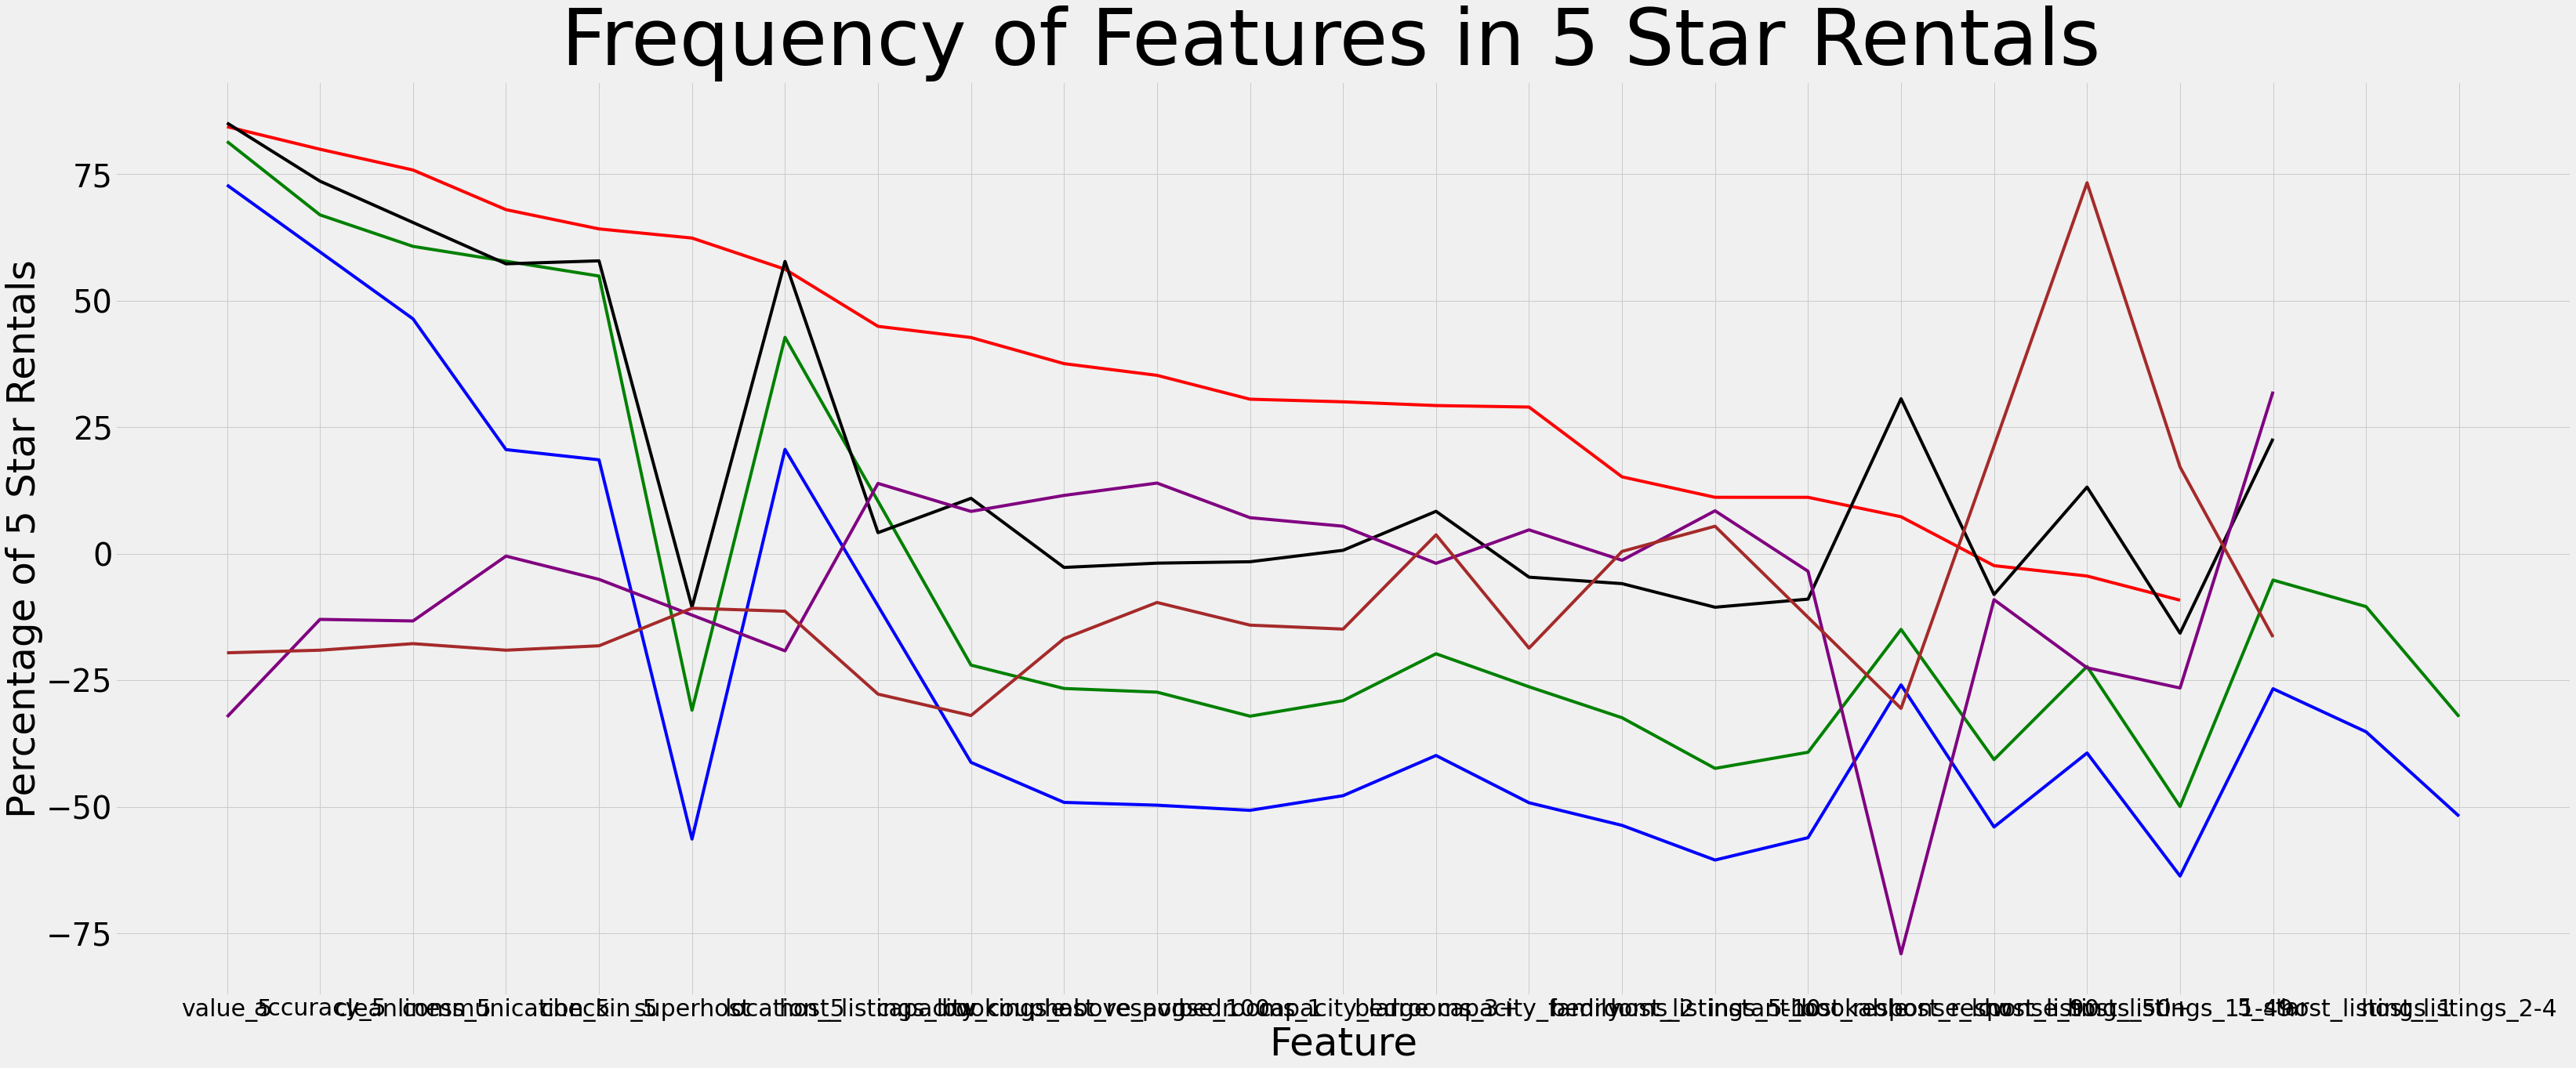

In [201]:
fig, ax = plt.subplots(figsize=(50,20))


p = sns.lineplot(data=five_star_stats, x='Metric', y='delta', color ='red' );
p = sns.lineplot(data=communication_stats, x='Metric', y='delta', color ='green' );
p = sns.lineplot(data=accuracy_stats, x='Metric', y='delta', color ='blue' );
p = sns.lineplot(data=cleanliness_stats, x='Metric', y='delta', color ='black' );
p = sns.lineplot(data=superhost_stats, x='Metric', y='delta', color ='purple' );
p = sns.lineplot(data=instant_book_stats, x='Metric', y='delta', color ='brown' );




p.set_ylabel("Percentage of 5 Star Rentals", fontsize = 50)

p.set_xlabel("Feature", fontsize = 50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=40)

#ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))

p.set_title("Frequency of Features in 5 Star Rentals ", fontsize = 100)
plt.figsize=(30,20) 

plt.show();

## Recommendations

- Don't have more properties than you can manage to the highest level of quality.
- Interface directly with your clients, and don't use instant booking.
- Be incredibly accurate in listing and communication with guests.
- Communicate well.
-- including communication about airbnbs system.
- being a superhost is beneficial, but make sure that you are striving for the highest degree of quality as well. That is more important than the superhost designation.


## Questions Answered

- Is there a significant advantage to being a Superhost? (is it worth all the effort to get this status and maintain it?)
- The benefits of being a 5 Star overall host, vs not being one. (again, is it worth all the work to have 5 Star overall rating)
- What factors are most important in determining a 5 Star Overall Rating? (what aspects should they most focus on)

### Significant Advantage to being a Superhost?
- 

### Analysis:
    - Even a small drop in accuracy results in a drop in the review score rating.

### Analysis:
- Units with a perfect accuracy rating were 72% more likely to have a perfect overall rating.
- Units with a perfect cleanliness rating were 64% more likely to have a perfect overall rating.
- Units with a perfect checkin rating were 63% more likely to have a perfect overall rating.
- Units with a perfect location rating were 58% more likely to have a perfect overall rating.
- Units with a perfect value rating were 56% more likely to have a perfect overall rating.


## Conclusion

## Further Work